# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

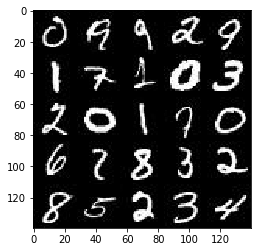

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

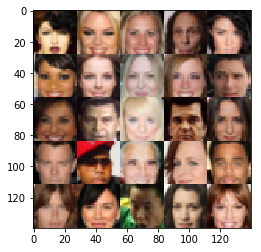

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,[None,image_width,image_height, image_channels])
    z = tf.placeholder(tf.float32,[None,z_dim])
    learning_rate = tf.placeholder(tf.float32,(None))

    return real_input,z,learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.02
    with tf.variable_scope('discriminator',reuse=reuse):
        #input layer is 32*32*3
        x1 = tf.layers.conv2d(images,64,5, strides = 2,padding='same')
        relu1 = tf.maximum(alpha * x1,x1)
        #16*16*64
        
        x2 = tf.layers.conv2d(relu1,128,5, strides = 2,padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2,bn2)
        #8*8*128
        x3 = tf.layers.conv2d(relu2,256,5, strides = 2,padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3,bn3)
        #4*4*256
        
        flat = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
    

    return output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.02
    with tf.variable_scope('generator',reuse = not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        #reshape
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1,x1)
        #4*4*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #8*8*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #16*16*128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
    
    return output





"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z,lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    n_total_batches = data_shape[0]
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                for epoch_i in range(epoch_count):
                    batch_counter = 0
        
                    for batch_images in get_batches(batch_size):
                        batch_counter +=1
            
                        batch_images = batch_images * 2.0
            
                #random noise for generator
                        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
            #run optimizers
                        _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                        _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
            
                        if batch_counter % 10 ==0:
                            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                            train_loss_g = g_loss.eval({input_z: batch_z})
                            print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, batch_counter, n_total_batches),
                                 "Discriminator Loss: {:.4f}".format(train_loss_d),
                                 "Generator Loss: {:.4f}".format(train_loss_g))
                        if batch_counter % 100 == 0:
                            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/60000:  Discriminator Loss: 0.2183 Generator Loss: 5.8071
Epoch 1/2 - Batch 20/60000:  Discriminator Loss: 0.6019 Generator Loss: 1.3435
Epoch 1/2 - Batch 30/60000:  Discriminator Loss: 1.2948 Generator Loss: 0.5636
Epoch 1/2 - Batch 40/60000:  Discriminator Loss: 1.5117 Generator Loss: 0.5008
Epoch 1/2 - Batch 50/60000:  Discriminator Loss: 2.5888 Generator Loss: 0.3221
Epoch 1/2 - Batch 60/60000:  Discriminator Loss: 3.1737 Generator Loss: 1.0681
Epoch 1/2 - Batch 70/60000:  Discriminator Loss: 1.2631 Generator Loss: 1.1645
Epoch 1/2 - Batch 80/60000:  Discriminator Loss: 1.3240 Generator Loss: 0.5848
Epoch 1/2 - Batch 90/60000:  Discriminator Loss: 1.3977 Generator Loss: 2.1200
Epoch 1/2 - Batch 100/60000:  Discriminator Loss: 1.5959 Generator Loss: 1.2799


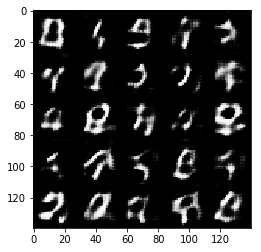

Epoch 1/2 - Batch 110/60000:  Discriminator Loss: 1.4321 Generator Loss: 0.4961
Epoch 1/2 - Batch 120/60000:  Discriminator Loss: 1.2113 Generator Loss: 0.8099
Epoch 1/2 - Batch 130/60000:  Discriminator Loss: 1.6281 Generator Loss: 1.4028
Epoch 1/2 - Batch 140/60000:  Discriminator Loss: 1.3640 Generator Loss: 1.0978
Epoch 1/2 - Batch 150/60000:  Discriminator Loss: 1.5201 Generator Loss: 0.4028
Epoch 1/2 - Batch 160/60000:  Discriminator Loss: 1.3949 Generator Loss: 0.6516
Epoch 1/2 - Batch 170/60000:  Discriminator Loss: 1.3713 Generator Loss: 0.4805
Epoch 1/2 - Batch 180/60000:  Discriminator Loss: 1.3856 Generator Loss: 0.8270
Epoch 1/2 - Batch 190/60000:  Discriminator Loss: 1.5290 Generator Loss: 0.5666
Epoch 1/2 - Batch 200/60000:  Discriminator Loss: 1.3664 Generator Loss: 0.8040


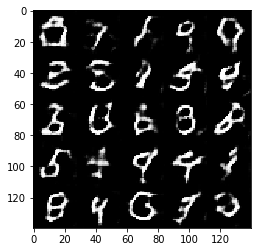

Epoch 1/2 - Batch 210/60000:  Discriminator Loss: 1.3332 Generator Loss: 1.4623
Epoch 1/2 - Batch 220/60000:  Discriminator Loss: 1.3531 Generator Loss: 1.2842
Epoch 1/2 - Batch 230/60000:  Discriminator Loss: 1.3300 Generator Loss: 0.6362
Epoch 1/2 - Batch 240/60000:  Discriminator Loss: 1.8687 Generator Loss: 0.2801
Epoch 1/2 - Batch 250/60000:  Discriminator Loss: 1.1508 Generator Loss: 0.9909
Epoch 1/2 - Batch 260/60000:  Discriminator Loss: 1.4504 Generator Loss: 0.6755
Epoch 1/2 - Batch 270/60000:  Discriminator Loss: 1.4613 Generator Loss: 1.8205
Epoch 1/2 - Batch 280/60000:  Discriminator Loss: 1.4989 Generator Loss: 0.3856
Epoch 1/2 - Batch 290/60000:  Discriminator Loss: 1.3027 Generator Loss: 0.9870
Epoch 1/2 - Batch 300/60000:  Discriminator Loss: 2.0460 Generator Loss: 0.2190


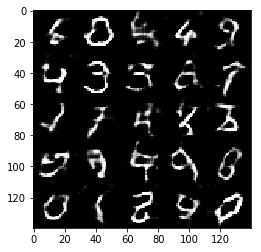

Epoch 1/2 - Batch 310/60000:  Discriminator Loss: 1.3736 Generator Loss: 1.3620
Epoch 1/2 - Batch 320/60000:  Discriminator Loss: 1.4541 Generator Loss: 0.4401
Epoch 1/2 - Batch 330/60000:  Discriminator Loss: 1.3602 Generator Loss: 0.9633
Epoch 1/2 - Batch 340/60000:  Discriminator Loss: 1.4559 Generator Loss: 0.4542
Epoch 1/2 - Batch 350/60000:  Discriminator Loss: 1.1086 Generator Loss: 1.3600
Epoch 1/2 - Batch 360/60000:  Discriminator Loss: 1.3436 Generator Loss: 1.0450
Epoch 1/2 - Batch 370/60000:  Discriminator Loss: 1.3067 Generator Loss: 0.5995
Epoch 1/2 - Batch 380/60000:  Discriminator Loss: 1.1939 Generator Loss: 1.2311
Epoch 1/2 - Batch 390/60000:  Discriminator Loss: 1.0358 Generator Loss: 0.9639
Epoch 1/2 - Batch 400/60000:  Discriminator Loss: 1.7390 Generator Loss: 0.2847


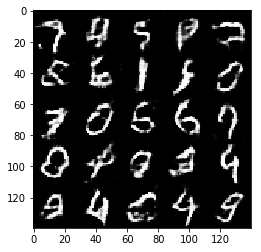

Epoch 1/2 - Batch 410/60000:  Discriminator Loss: 1.6644 Generator Loss: 0.3280
Epoch 1/2 - Batch 420/60000:  Discriminator Loss: 1.1601 Generator Loss: 0.9756
Epoch 1/2 - Batch 430/60000:  Discriminator Loss: 1.4798 Generator Loss: 1.5698
Epoch 1/2 - Batch 440/60000:  Discriminator Loss: 1.3957 Generator Loss: 0.4925
Epoch 1/2 - Batch 450/60000:  Discriminator Loss: 1.0955 Generator Loss: 1.4028
Epoch 1/2 - Batch 460/60000:  Discriminator Loss: 1.6535 Generator Loss: 1.5366
Epoch 1/2 - Batch 470/60000:  Discriminator Loss: 1.2407 Generator Loss: 0.7068
Epoch 1/2 - Batch 480/60000:  Discriminator Loss: 1.6405 Generator Loss: 0.3256
Epoch 1/2 - Batch 490/60000:  Discriminator Loss: 1.9400 Generator Loss: 0.2499
Epoch 1/2 - Batch 500/60000:  Discriminator Loss: 1.2247 Generator Loss: 0.7152


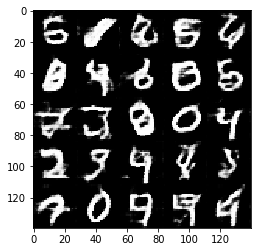

Epoch 1/2 - Batch 510/60000:  Discriminator Loss: 1.5569 Generator Loss: 0.3690
Epoch 1/2 - Batch 520/60000:  Discriminator Loss: 1.0638 Generator Loss: 0.9542
Epoch 1/2 - Batch 530/60000:  Discriminator Loss: 1.3737 Generator Loss: 1.5667
Epoch 1/2 - Batch 540/60000:  Discriminator Loss: 1.0411 Generator Loss: 1.1306
Epoch 1/2 - Batch 550/60000:  Discriminator Loss: 2.0415 Generator Loss: 1.7252
Epoch 1/2 - Batch 560/60000:  Discriminator Loss: 1.3652 Generator Loss: 0.6063
Epoch 1/2 - Batch 570/60000:  Discriminator Loss: 1.1939 Generator Loss: 0.9106
Epoch 1/2 - Batch 580/60000:  Discriminator Loss: 1.1702 Generator Loss: 1.0830
Epoch 1/2 - Batch 590/60000:  Discriminator Loss: 1.2556 Generator Loss: 0.6170
Epoch 1/2 - Batch 600/60000:  Discriminator Loss: 1.8051 Generator Loss: 0.2675


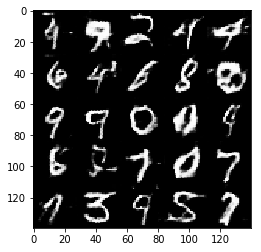

Epoch 1/2 - Batch 610/60000:  Discriminator Loss: 1.5159 Generator Loss: 0.4587
Epoch 1/2 - Batch 620/60000:  Discriminator Loss: 1.4853 Generator Loss: 0.4795
Epoch 1/2 - Batch 630/60000:  Discriminator Loss: 1.1556 Generator Loss: 0.8655
Epoch 1/2 - Batch 640/60000:  Discriminator Loss: 1.1521 Generator Loss: 0.9752
Epoch 1/2 - Batch 650/60000:  Discriminator Loss: 1.3177 Generator Loss: 0.8838
Epoch 1/2 - Batch 660/60000:  Discriminator Loss: 2.0624 Generator Loss: 0.2133
Epoch 1/2 - Batch 670/60000:  Discriminator Loss: 1.3912 Generator Loss: 0.4989
Epoch 1/2 - Batch 680/60000:  Discriminator Loss: 1.8740 Generator Loss: 0.2463
Epoch 1/2 - Batch 690/60000:  Discriminator Loss: 1.1796 Generator Loss: 0.8799
Epoch 1/2 - Batch 700/60000:  Discriminator Loss: 1.2067 Generator Loss: 0.8068


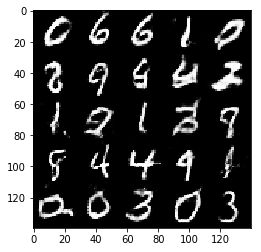

Epoch 1/2 - Batch 710/60000:  Discriminator Loss: 1.3047 Generator Loss: 0.5542
Epoch 1/2 - Batch 720/60000:  Discriminator Loss: 1.2363 Generator Loss: 1.4093
Epoch 1/2 - Batch 730/60000:  Discriminator Loss: 1.7279 Generator Loss: 0.3562
Epoch 1/2 - Batch 740/60000:  Discriminator Loss: 1.6852 Generator Loss: 0.3068
Epoch 1/2 - Batch 750/60000:  Discriminator Loss: 1.4103 Generator Loss: 0.4825
Epoch 1/2 - Batch 760/60000:  Discriminator Loss: 1.5138 Generator Loss: 0.3709
Epoch 1/2 - Batch 770/60000:  Discriminator Loss: 1.2628 Generator Loss: 0.6658
Epoch 1/2 - Batch 780/60000:  Discriminator Loss: 2.2830 Generator Loss: 0.1726
Epoch 1/2 - Batch 790/60000:  Discriminator Loss: 2.2245 Generator Loss: 0.2257
Epoch 1/2 - Batch 800/60000:  Discriminator Loss: 1.7448 Generator Loss: 0.3546


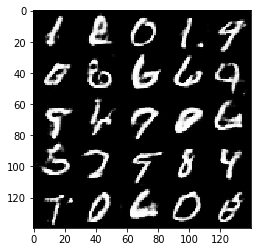

Epoch 1/2 - Batch 810/60000:  Discriminator Loss: 1.2548 Generator Loss: 0.6535
Epoch 1/2 - Batch 820/60000:  Discriminator Loss: 1.2107 Generator Loss: 0.6917
Epoch 1/2 - Batch 830/60000:  Discriminator Loss: 1.0551 Generator Loss: 0.8110
Epoch 1/2 - Batch 840/60000:  Discriminator Loss: 1.9440 Generator Loss: 0.2732
Epoch 1/2 - Batch 850/60000:  Discriminator Loss: 1.6681 Generator Loss: 0.3406
Epoch 1/2 - Batch 860/60000:  Discriminator Loss: 1.4570 Generator Loss: 0.5228
Epoch 1/2 - Batch 870/60000:  Discriminator Loss: 1.2640 Generator Loss: 0.6091
Epoch 1/2 - Batch 880/60000:  Discriminator Loss: 1.2217 Generator Loss: 0.6774
Epoch 1/2 - Batch 890/60000:  Discriminator Loss: 1.7761 Generator Loss: 0.3162
Epoch 1/2 - Batch 900/60000:  Discriminator Loss: 1.2575 Generator Loss: 1.1421


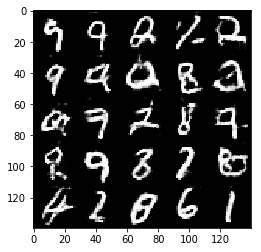

Epoch 1/2 - Batch 910/60000:  Discriminator Loss: 1.3542 Generator Loss: 0.5922
Epoch 1/2 - Batch 920/60000:  Discriminator Loss: 1.4667 Generator Loss: 0.5445
Epoch 1/2 - Batch 930/60000:  Discriminator Loss: 1.3665 Generator Loss: 0.6156
Epoch 2/2 - Batch 10/60000:  Discriminator Loss: 1.3571 Generator Loss: 1.3435
Epoch 2/2 - Batch 20/60000:  Discriminator Loss: 1.3903 Generator Loss: 0.5466
Epoch 2/2 - Batch 30/60000:  Discriminator Loss: 1.4800 Generator Loss: 0.5166
Epoch 2/2 - Batch 40/60000:  Discriminator Loss: 1.9551 Generator Loss: 0.2362
Epoch 2/2 - Batch 50/60000:  Discriminator Loss: 1.2348 Generator Loss: 0.7777
Epoch 2/2 - Batch 60/60000:  Discriminator Loss: 1.3626 Generator Loss: 0.4662
Epoch 2/2 - Batch 70/60000:  Discriminator Loss: 1.4015 Generator Loss: 1.0239
Epoch 2/2 - Batch 80/60000:  Discriminator Loss: 1.3972 Generator Loss: 0.5249
Epoch 2/2 - Batch 90/60000:  Discriminator Loss: 1.2063 Generator Loss: 0.6994
Epoch 2/2 - Batch 100/60000:  Discriminator Loss:

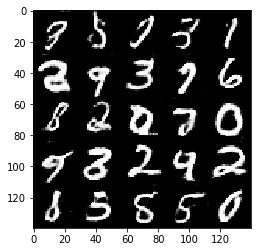

Epoch 2/2 - Batch 110/60000:  Discriminator Loss: 1.3344 Generator Loss: 0.6933
Epoch 2/2 - Batch 120/60000:  Discriminator Loss: 1.8543 Generator Loss: 0.2344
Epoch 2/2 - Batch 130/60000:  Discriminator Loss: 1.4573 Generator Loss: 0.5468
Epoch 2/2 - Batch 140/60000:  Discriminator Loss: 1.2618 Generator Loss: 1.0488
Epoch 2/2 - Batch 150/60000:  Discriminator Loss: 1.3394 Generator Loss: 0.5296
Epoch 2/2 - Batch 160/60000:  Discriminator Loss: 1.7353 Generator Loss: 0.3595
Epoch 2/2 - Batch 170/60000:  Discriminator Loss: 1.0489 Generator Loss: 0.8638
Epoch 2/2 - Batch 180/60000:  Discriminator Loss: 1.2963 Generator Loss: 0.6101
Epoch 2/2 - Batch 190/60000:  Discriminator Loss: 1.5898 Generator Loss: 1.9453
Epoch 2/2 - Batch 200/60000:  Discriminator Loss: 1.4872 Generator Loss: 0.4835


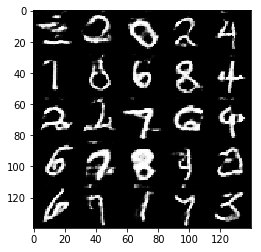

Epoch 2/2 - Batch 210/60000:  Discriminator Loss: 1.3800 Generator Loss: 0.6908
Epoch 2/2 - Batch 220/60000:  Discriminator Loss: 2.2572 Generator Loss: 0.1646
Epoch 2/2 - Batch 230/60000:  Discriminator Loss: 1.7273 Generator Loss: 0.3320
Epoch 2/2 - Batch 240/60000:  Discriminator Loss: 1.4917 Generator Loss: 1.8800
Epoch 2/2 - Batch 250/60000:  Discriminator Loss: 1.2364 Generator Loss: 0.7376
Epoch 2/2 - Batch 260/60000:  Discriminator Loss: 1.2359 Generator Loss: 0.7291
Epoch 2/2 - Batch 270/60000:  Discriminator Loss: 1.1284 Generator Loss: 0.9553
Epoch 2/2 - Batch 280/60000:  Discriminator Loss: 1.3960 Generator Loss: 0.4808
Epoch 2/2 - Batch 290/60000:  Discriminator Loss: 0.9946 Generator Loss: 0.9873
Epoch 2/2 - Batch 300/60000:  Discriminator Loss: 1.4379 Generator Loss: 0.4733


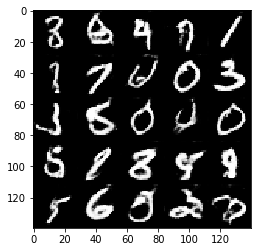

Epoch 2/2 - Batch 310/60000:  Discriminator Loss: 1.4260 Generator Loss: 0.4639
Epoch 2/2 - Batch 320/60000:  Discriminator Loss: 1.4621 Generator Loss: 0.5029
Epoch 2/2 - Batch 330/60000:  Discriminator Loss: 1.2396 Generator Loss: 0.8282
Epoch 2/2 - Batch 340/60000:  Discriminator Loss: 0.9815 Generator Loss: 1.5235
Epoch 2/2 - Batch 350/60000:  Discriminator Loss: 1.8789 Generator Loss: 0.3145
Epoch 2/2 - Batch 360/60000:  Discriminator Loss: 1.7634 Generator Loss: 0.2919
Epoch 2/2 - Batch 370/60000:  Discriminator Loss: 1.1136 Generator Loss: 1.0302
Epoch 2/2 - Batch 380/60000:  Discriminator Loss: 0.9142 Generator Loss: 1.3058
Epoch 2/2 - Batch 390/60000:  Discriminator Loss: 1.5710 Generator Loss: 0.4667
Epoch 2/2 - Batch 400/60000:  Discriminator Loss: 1.4257 Generator Loss: 0.4702


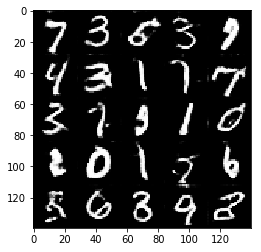

Epoch 2/2 - Batch 410/60000:  Discriminator Loss: 1.4625 Generator Loss: 0.6116
Epoch 2/2 - Batch 420/60000:  Discriminator Loss: 1.3953 Generator Loss: 0.8829
Epoch 2/2 - Batch 430/60000:  Discriminator Loss: 1.0959 Generator Loss: 0.7711
Epoch 2/2 - Batch 440/60000:  Discriminator Loss: 1.6475 Generator Loss: 0.3783
Epoch 2/2 - Batch 450/60000:  Discriminator Loss: 0.7929 Generator Loss: 1.2520
Epoch 2/2 - Batch 460/60000:  Discriminator Loss: 1.1934 Generator Loss: 0.7551
Epoch 2/2 - Batch 470/60000:  Discriminator Loss: 1.1459 Generator Loss: 1.0479
Epoch 2/2 - Batch 480/60000:  Discriminator Loss: 1.4871 Generator Loss: 0.4455
Epoch 2/2 - Batch 490/60000:  Discriminator Loss: 1.2654 Generator Loss: 0.6097
Epoch 2/2 - Batch 500/60000:  Discriminator Loss: 1.4210 Generator Loss: 0.4262


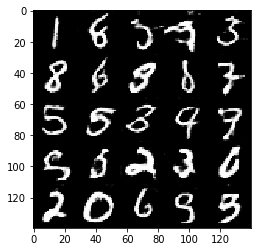

Epoch 2/2 - Batch 510/60000:  Discriminator Loss: 1.2811 Generator Loss: 0.5773
Epoch 2/2 - Batch 520/60000:  Discriminator Loss: 1.1638 Generator Loss: 0.8414
Epoch 2/2 - Batch 530/60000:  Discriminator Loss: 1.4434 Generator Loss: 1.6264
Epoch 2/2 - Batch 540/60000:  Discriminator Loss: 1.4875 Generator Loss: 0.5037
Epoch 2/2 - Batch 550/60000:  Discriminator Loss: 1.7230 Generator Loss: 0.3215
Epoch 2/2 - Batch 560/60000:  Discriminator Loss: 1.6538 Generator Loss: 0.3993
Epoch 2/2 - Batch 570/60000:  Discriminator Loss: 1.2142 Generator Loss: 1.6593
Epoch 2/2 - Batch 580/60000:  Discriminator Loss: 1.3401 Generator Loss: 0.5216
Epoch 2/2 - Batch 590/60000:  Discriminator Loss: 1.3316 Generator Loss: 1.0376
Epoch 2/2 - Batch 600/60000:  Discriminator Loss: 1.4141 Generator Loss: 0.4858


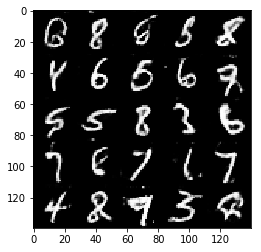

Epoch 2/2 - Batch 610/60000:  Discriminator Loss: 0.9541 Generator Loss: 1.2716
Epoch 2/2 - Batch 620/60000:  Discriminator Loss: 1.3493 Generator Loss: 0.6193
Epoch 2/2 - Batch 630/60000:  Discriminator Loss: 0.9042 Generator Loss: 1.1278
Epoch 2/2 - Batch 640/60000:  Discriminator Loss: 1.0408 Generator Loss: 1.1187
Epoch 2/2 - Batch 650/60000:  Discriminator Loss: 1.0782 Generator Loss: 0.9062
Epoch 2/2 - Batch 660/60000:  Discriminator Loss: 1.3439 Generator Loss: 1.5564
Epoch 2/2 - Batch 670/60000:  Discriminator Loss: 1.4398 Generator Loss: 0.6608
Epoch 2/2 - Batch 680/60000:  Discriminator Loss: 1.8713 Generator Loss: 0.2475
Epoch 2/2 - Batch 690/60000:  Discriminator Loss: 1.0040 Generator Loss: 0.7795
Epoch 2/2 - Batch 700/60000:  Discriminator Loss: 0.8646 Generator Loss: 1.4171


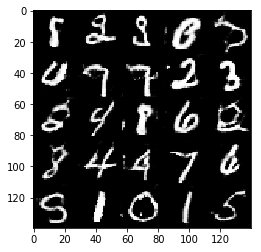

Epoch 2/2 - Batch 710/60000:  Discriminator Loss: 0.9310 Generator Loss: 0.9759
Epoch 2/2 - Batch 720/60000:  Discriminator Loss: 1.2288 Generator Loss: 0.7753
Epoch 2/2 - Batch 730/60000:  Discriminator Loss: 1.1413 Generator Loss: 1.2289
Epoch 2/2 - Batch 740/60000:  Discriminator Loss: 0.9790 Generator Loss: 1.3220
Epoch 2/2 - Batch 750/60000:  Discriminator Loss: 0.7650 Generator Loss: 1.8025
Epoch 2/2 - Batch 760/60000:  Discriminator Loss: 2.3643 Generator Loss: 0.1493
Epoch 2/2 - Batch 770/60000:  Discriminator Loss: 1.2476 Generator Loss: 0.6817
Epoch 2/2 - Batch 780/60000:  Discriminator Loss: 1.9193 Generator Loss: 0.2795
Epoch 2/2 - Batch 790/60000:  Discriminator Loss: 1.5071 Generator Loss: 0.5002
Epoch 2/2 - Batch 800/60000:  Discriminator Loss: 1.4727 Generator Loss: 0.5121


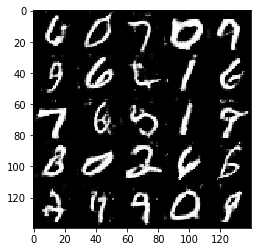

Epoch 2/2 - Batch 810/60000:  Discriminator Loss: 0.8863 Generator Loss: 1.0837
Epoch 2/2 - Batch 820/60000:  Discriminator Loss: 1.8485 Generator Loss: 0.2799
Epoch 2/2 - Batch 830/60000:  Discriminator Loss: 1.4616 Generator Loss: 3.6366
Epoch 2/2 - Batch 840/60000:  Discriminator Loss: 1.0917 Generator Loss: 0.7961
Epoch 2/2 - Batch 850/60000:  Discriminator Loss: 1.1362 Generator Loss: 0.6295
Epoch 2/2 - Batch 860/60000:  Discriminator Loss: 0.7423 Generator Loss: 1.0493
Epoch 2/2 - Batch 870/60000:  Discriminator Loss: 1.8764 Generator Loss: 0.2797
Epoch 2/2 - Batch 880/60000:  Discriminator Loss: 0.9967 Generator Loss: 0.7308
Epoch 2/2 - Batch 890/60000:  Discriminator Loss: 0.9561 Generator Loss: 0.9053
Epoch 2/2 - Batch 900/60000:  Discriminator Loss: 1.0831 Generator Loss: 0.6548


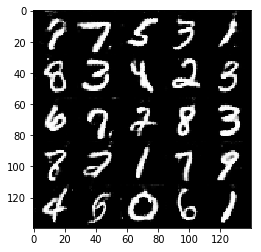

Epoch 2/2 - Batch 910/60000:  Discriminator Loss: 2.3013 Generator Loss: 0.1788
Epoch 2/2 - Batch 920/60000:  Discriminator Loss: 0.9872 Generator Loss: 0.8755
Epoch 2/2 - Batch 930/60000:  Discriminator Loss: 2.1280 Generator Loss: 0.2711
Epoch 1/2 - Batch 10/60000:  Discriminator Loss: 2.6708 Generator Loss: 2.9877
Epoch 1/2 - Batch 20/60000:  Discriminator Loss: 1.5236 Generator Loss: 0.3947
Epoch 1/2 - Batch 30/60000:  Discriminator Loss: 1.4409 Generator Loss: 0.6852
Epoch 1/2 - Batch 40/60000:  Discriminator Loss: 2.3446 Generator Loss: 0.2110
Epoch 1/2 - Batch 50/60000:  Discriminator Loss: 1.8187 Generator Loss: 0.3045
Epoch 1/2 - Batch 60/60000:  Discriminator Loss: 1.0778 Generator Loss: 1.1714


KeyboardInterrupt: 

In [12]:
batch_size = 64
z_dim = 120
learning_rate = 0.004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/202599:  Discriminator Loss: 0.4636 Generator Loss: 3.6311
Epoch 1/1 - Batch 20/202599:  Discriminator Loss: 0.7177 Generator Loss: 8.8687
Epoch 1/1 - Batch 30/202599:  Discriminator Loss: 1.4349 Generator Loss: 2.1795
Epoch 1/1 - Batch 40/202599:  Discriminator Loss: 2.2397 Generator Loss: 0.2368
Epoch 1/1 - Batch 50/202599:  Discriminator Loss: 1.2304 Generator Loss: 0.7302
Epoch 1/1 - Batch 60/202599:  Discriminator Loss: 1.1907 Generator Loss: 0.8123
Epoch 1/1 - Batch 70/202599:  Discriminator Loss: 1.2853 Generator Loss: 0.7171
Epoch 1/1 - Batch 80/202599:  Discriminator Loss: 2.0870 Generator Loss: 0.3108
Epoch 1/1 - Batch 90/202599:  Discriminator Loss: 1.2637 Generator Loss: 0.9294
Epoch 1/1 - Batch 100/202599:  Discriminator Loss: 1.5098 Generator Loss: 0.6158


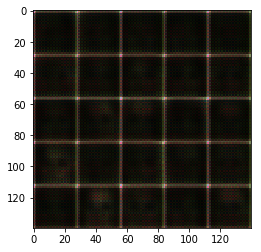

Epoch 1/1 - Batch 110/202599:  Discriminator Loss: 1.0031 Generator Loss: 1.3036
Epoch 1/1 - Batch 120/202599:  Discriminator Loss: 1.9756 Generator Loss: 0.2766
Epoch 1/1 - Batch 130/202599:  Discriminator Loss: 1.4895 Generator Loss: 2.2248
Epoch 1/1 - Batch 140/202599:  Discriminator Loss: 2.0632 Generator Loss: 0.2903
Epoch 1/1 - Batch 150/202599:  Discriminator Loss: 1.6361 Generator Loss: 0.3817
Epoch 1/1 - Batch 160/202599:  Discriminator Loss: 1.2624 Generator Loss: 1.2059
Epoch 1/1 - Batch 170/202599:  Discriminator Loss: 0.8362 Generator Loss: 2.5248
Epoch 1/1 - Batch 180/202599:  Discriminator Loss: 1.2703 Generator Loss: 0.6068
Epoch 1/1 - Batch 190/202599:  Discriminator Loss: 1.2667 Generator Loss: 2.9381
Epoch 1/1 - Batch 200/202599:  Discriminator Loss: 2.1813 Generator Loss: 0.2881


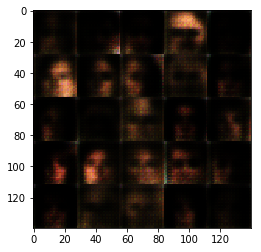

Epoch 1/1 - Batch 210/202599:  Discriminator Loss: 1.3367 Generator Loss: 0.6205
Epoch 1/1 - Batch 220/202599:  Discriminator Loss: 1.1605 Generator Loss: 0.9017
Epoch 1/1 - Batch 230/202599:  Discriminator Loss: 0.9790 Generator Loss: 1.1716
Epoch 1/1 - Batch 240/202599:  Discriminator Loss: 1.0395 Generator Loss: 1.2160
Epoch 1/1 - Batch 250/202599:  Discriminator Loss: 0.9509 Generator Loss: 1.5592
Epoch 1/1 - Batch 260/202599:  Discriminator Loss: 1.2654 Generator Loss: 0.8969
Epoch 1/1 - Batch 270/202599:  Discriminator Loss: 1.0910 Generator Loss: 1.0447
Epoch 1/1 - Batch 280/202599:  Discriminator Loss: 1.0148 Generator Loss: 1.0029
Epoch 1/1 - Batch 290/202599:  Discriminator Loss: 1.3487 Generator Loss: 1.0714
Epoch 1/1 - Batch 300/202599:  Discriminator Loss: 1.1132 Generator Loss: 1.3754


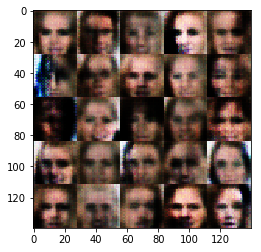

Epoch 1/1 - Batch 310/202599:  Discriminator Loss: 1.4171 Generator Loss: 0.5668
Epoch 1/1 - Batch 320/202599:  Discriminator Loss: 1.3755 Generator Loss: 2.1913
Epoch 1/1 - Batch 330/202599:  Discriminator Loss: 1.1152 Generator Loss: 2.0821
Epoch 1/1 - Batch 340/202599:  Discriminator Loss: 1.1451 Generator Loss: 0.8135
Epoch 1/1 - Batch 350/202599:  Discriminator Loss: 0.7269 Generator Loss: 2.2684
Epoch 1/1 - Batch 360/202599:  Discriminator Loss: 0.7480 Generator Loss: 1.6609
Epoch 1/1 - Batch 370/202599:  Discriminator Loss: 1.3527 Generator Loss: 2.6273
Epoch 1/1 - Batch 380/202599:  Discriminator Loss: 1.1559 Generator Loss: 0.8356
Epoch 1/1 - Batch 390/202599:  Discriminator Loss: 0.8336 Generator Loss: 1.5328
Epoch 1/1 - Batch 400/202599:  Discriminator Loss: 1.2106 Generator Loss: 0.7602


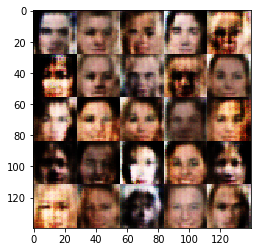

Epoch 1/1 - Batch 410/202599:  Discriminator Loss: 1.3336 Generator Loss: 0.7455
Epoch 1/1 - Batch 420/202599:  Discriminator Loss: 1.2577 Generator Loss: 0.6484
Epoch 1/1 - Batch 430/202599:  Discriminator Loss: 1.4843 Generator Loss: 0.4915
Epoch 1/1 - Batch 440/202599:  Discriminator Loss: 1.7222 Generator Loss: 0.3294
Epoch 1/1 - Batch 450/202599:  Discriminator Loss: 0.7248 Generator Loss: 1.4769
Epoch 1/1 - Batch 460/202599:  Discriminator Loss: 1.2421 Generator Loss: 0.6162
Epoch 1/1 - Batch 470/202599:  Discriminator Loss: 0.9385 Generator Loss: 1.0882
Epoch 1/1 - Batch 480/202599:  Discriminator Loss: 1.8493 Generator Loss: 0.3119
Epoch 1/1 - Batch 490/202599:  Discriminator Loss: 1.3009 Generator Loss: 0.6824
Epoch 1/1 - Batch 500/202599:  Discriminator Loss: 0.8077 Generator Loss: 2.2554


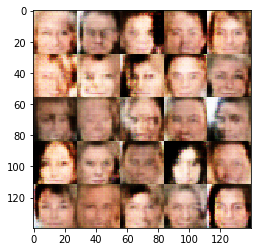

Epoch 1/1 - Batch 510/202599:  Discriminator Loss: 0.9224 Generator Loss: 1.1226
Epoch 1/1 - Batch 520/202599:  Discriminator Loss: 1.0292 Generator Loss: 0.8148
Epoch 1/1 - Batch 530/202599:  Discriminator Loss: 1.3030 Generator Loss: 0.9336
Epoch 1/1 - Batch 540/202599:  Discriminator Loss: 0.6707 Generator Loss: 1.7865
Epoch 1/1 - Batch 550/202599:  Discriminator Loss: 1.2710 Generator Loss: 1.3704
Epoch 1/1 - Batch 560/202599:  Discriminator Loss: 1.1220 Generator Loss: 2.2437
Epoch 1/1 - Batch 570/202599:  Discriminator Loss: 1.3626 Generator Loss: 0.4841
Epoch 1/1 - Batch 580/202599:  Discriminator Loss: 0.9155 Generator Loss: 1.4475
Epoch 1/1 - Batch 590/202599:  Discriminator Loss: 1.0044 Generator Loss: 1.1056
Epoch 1/1 - Batch 600/202599:  Discriminator Loss: 1.0891 Generator Loss: 1.4639


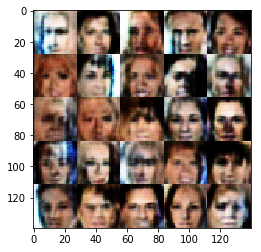

Epoch 1/1 - Batch 610/202599:  Discriminator Loss: 1.2103 Generator Loss: 0.9797
Epoch 1/1 - Batch 620/202599:  Discriminator Loss: 1.2392 Generator Loss: 1.0989
Epoch 1/1 - Batch 630/202599:  Discriminator Loss: 1.1797 Generator Loss: 1.9599
Epoch 1/1 - Batch 640/202599:  Discriminator Loss: 1.5446 Generator Loss: 0.5337
Epoch 1/1 - Batch 650/202599:  Discriminator Loss: 0.6799 Generator Loss: 1.6893
Epoch 1/1 - Batch 660/202599:  Discriminator Loss: 1.4240 Generator Loss: 0.4959
Epoch 1/1 - Batch 670/202599:  Discriminator Loss: 0.4803 Generator Loss: 2.8421
Epoch 1/1 - Batch 680/202599:  Discriminator Loss: 1.4463 Generator Loss: 0.8751
Epoch 1/1 - Batch 690/202599:  Discriminator Loss: 1.1550 Generator Loss: 0.7242
Epoch 1/1 - Batch 700/202599:  Discriminator Loss: 1.3343 Generator Loss: 1.1060


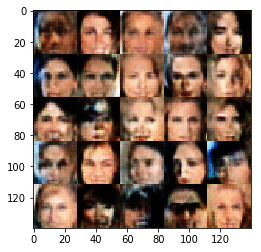

Epoch 1/1 - Batch 710/202599:  Discriminator Loss: 0.7835 Generator Loss: 4.0304
Epoch 1/1 - Batch 720/202599:  Discriminator Loss: 1.7396 Generator Loss: 0.3334
Epoch 1/1 - Batch 730/202599:  Discriminator Loss: 1.3567 Generator Loss: 0.6016
Epoch 1/1 - Batch 740/202599:  Discriminator Loss: 1.2988 Generator Loss: 1.4471
Epoch 1/1 - Batch 750/202599:  Discriminator Loss: 1.0094 Generator Loss: 0.8433
Epoch 1/1 - Batch 760/202599:  Discriminator Loss: 0.7382 Generator Loss: 1.2928
Epoch 1/1 - Batch 770/202599:  Discriminator Loss: 1.0836 Generator Loss: 1.0252
Epoch 1/1 - Batch 780/202599:  Discriminator Loss: 1.3644 Generator Loss: 0.8417
Epoch 1/1 - Batch 790/202599:  Discriminator Loss: 1.3179 Generator Loss: 0.7080
Epoch 1/1 - Batch 800/202599:  Discriminator Loss: 1.1105 Generator Loss: 1.1238


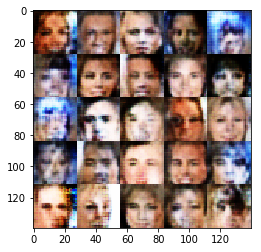

Epoch 1/1 - Batch 810/202599:  Discriminator Loss: 1.1269 Generator Loss: 1.5942
Epoch 1/1 - Batch 820/202599:  Discriminator Loss: 1.2946 Generator Loss: 0.7498
Epoch 1/1 - Batch 830/202599:  Discriminator Loss: 1.1491 Generator Loss: 1.0456
Epoch 1/1 - Batch 840/202599:  Discriminator Loss: 1.3025 Generator Loss: 0.5850
Epoch 1/1 - Batch 850/202599:  Discriminator Loss: 1.2391 Generator Loss: 0.9255
Epoch 1/1 - Batch 860/202599:  Discriminator Loss: 0.9191 Generator Loss: 4.2675
Epoch 1/1 - Batch 870/202599:  Discriminator Loss: 1.2092 Generator Loss: 0.7602
Epoch 1/1 - Batch 880/202599:  Discriminator Loss: 1.4219 Generator Loss: 0.6248
Epoch 1/1 - Batch 890/202599:  Discriminator Loss: 1.0481 Generator Loss: 1.5864
Epoch 1/1 - Batch 900/202599:  Discriminator Loss: 1.1433 Generator Loss: 1.0619


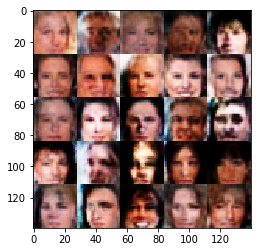

Epoch 1/1 - Batch 910/202599:  Discriminator Loss: 1.6589 Generator Loss: 0.3529
Epoch 1/1 - Batch 920/202599:  Discriminator Loss: 1.3632 Generator Loss: 0.5720
Epoch 1/1 - Batch 930/202599:  Discriminator Loss: 1.3796 Generator Loss: 0.5229
Epoch 1/1 - Batch 940/202599:  Discriminator Loss: 1.1844 Generator Loss: 0.7547
Epoch 1/1 - Batch 950/202599:  Discriminator Loss: 1.3187 Generator Loss: 0.7983
Epoch 1/1 - Batch 960/202599:  Discriminator Loss: 1.0850 Generator Loss: 0.8067
Epoch 1/1 - Batch 970/202599:  Discriminator Loss: 1.0383 Generator Loss: 0.8399
Epoch 1/1 - Batch 980/202599:  Discriminator Loss: 0.9555 Generator Loss: 0.9172
Epoch 1/1 - Batch 990/202599:  Discriminator Loss: 1.6263 Generator Loss: 0.5069
Epoch 1/1 - Batch 1000/202599:  Discriminator Loss: 1.1860 Generator Loss: 1.1619


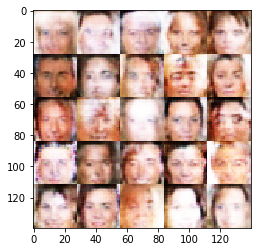

Epoch 1/1 - Batch 1010/202599:  Discriminator Loss: 1.3024 Generator Loss: 1.9227
Epoch 1/1 - Batch 1020/202599:  Discriminator Loss: 1.0934 Generator Loss: 0.7754
Epoch 1/1 - Batch 1030/202599:  Discriminator Loss: 1.3504 Generator Loss: 1.3609
Epoch 1/1 - Batch 1040/202599:  Discriminator Loss: 0.9932 Generator Loss: 1.1900
Epoch 1/1 - Batch 1050/202599:  Discriminator Loss: 1.3860 Generator Loss: 0.5163
Epoch 1/1 - Batch 1060/202599:  Discriminator Loss: 1.2589 Generator Loss: 0.9253
Epoch 1/1 - Batch 1070/202599:  Discriminator Loss: 1.2216 Generator Loss: 0.9008
Epoch 1/1 - Batch 1080/202599:  Discriminator Loss: 1.4069 Generator Loss: 0.6947
Epoch 1/1 - Batch 1090/202599:  Discriminator Loss: 1.3933 Generator Loss: 0.5674
Epoch 1/1 - Batch 1100/202599:  Discriminator Loss: 1.0796 Generator Loss: 0.9770


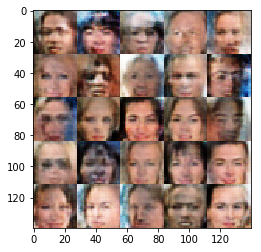

Epoch 1/1 - Batch 1110/202599:  Discriminator Loss: 0.9741 Generator Loss: 1.3625
Epoch 1/1 - Batch 1120/202599:  Discriminator Loss: 1.3161 Generator Loss: 0.5585
Epoch 1/1 - Batch 1130/202599:  Discriminator Loss: 1.4873 Generator Loss: 0.4558
Epoch 1/1 - Batch 1140/202599:  Discriminator Loss: 1.1863 Generator Loss: 0.8793
Epoch 1/1 - Batch 1150/202599:  Discriminator Loss: 1.2285 Generator Loss: 1.0208
Epoch 1/1 - Batch 1160/202599:  Discriminator Loss: 1.3565 Generator Loss: 0.6068
Epoch 1/1 - Batch 1170/202599:  Discriminator Loss: 1.2133 Generator Loss: 0.9837
Epoch 1/1 - Batch 1180/202599:  Discriminator Loss: 1.5096 Generator Loss: 0.4344
Epoch 1/1 - Batch 1190/202599:  Discriminator Loss: 1.5944 Generator Loss: 0.4971
Epoch 1/1 - Batch 1200/202599:  Discriminator Loss: 1.2882 Generator Loss: 0.6117


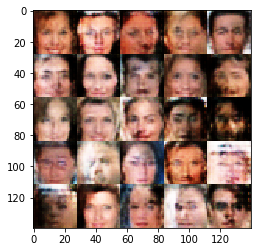

Epoch 1/1 - Batch 1210/202599:  Discriminator Loss: 0.9627 Generator Loss: 1.1853
Epoch 1/1 - Batch 1220/202599:  Discriminator Loss: 1.2100 Generator Loss: 1.2712
Epoch 1/1 - Batch 1230/202599:  Discriminator Loss: 1.8055 Generator Loss: 0.3069
Epoch 1/1 - Batch 1240/202599:  Discriminator Loss: 1.5556 Generator Loss: 0.5325
Epoch 1/1 - Batch 1250/202599:  Discriminator Loss: 1.0160 Generator Loss: 0.9665
Epoch 1/1 - Batch 1260/202599:  Discriminator Loss: 1.4163 Generator Loss: 1.8606
Epoch 1/1 - Batch 1270/202599:  Discriminator Loss: 1.3275 Generator Loss: 0.7817
Epoch 1/1 - Batch 1280/202599:  Discriminator Loss: 1.1556 Generator Loss: 1.1517
Epoch 1/1 - Batch 1290/202599:  Discriminator Loss: 1.2901 Generator Loss: 0.6932
Epoch 1/1 - Batch 1300/202599:  Discriminator Loss: 1.2928 Generator Loss: 0.6104


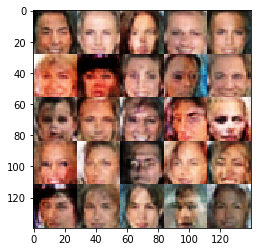

Epoch 1/1 - Batch 1310/202599:  Discriminator Loss: 1.2765 Generator Loss: 0.7167
Epoch 1/1 - Batch 1320/202599:  Discriminator Loss: 1.3915 Generator Loss: 0.5933
Epoch 1/1 - Batch 1330/202599:  Discriminator Loss: 1.5307 Generator Loss: 0.4048
Epoch 1/1 - Batch 1340/202599:  Discriminator Loss: 1.3976 Generator Loss: 0.9150
Epoch 1/1 - Batch 1350/202599:  Discriminator Loss: 1.2341 Generator Loss: 0.9377
Epoch 1/1 - Batch 1360/202599:  Discriminator Loss: 1.2237 Generator Loss: 0.8923
Epoch 1/1 - Batch 1370/202599:  Discriminator Loss: 0.8658 Generator Loss: 1.2447
Epoch 1/1 - Batch 1380/202599:  Discriminator Loss: 1.2953 Generator Loss: 0.6574
Epoch 1/1 - Batch 1390/202599:  Discriminator Loss: 1.3443 Generator Loss: 2.0723
Epoch 1/1 - Batch 1400/202599:  Discriminator Loss: 1.3515 Generator Loss: 0.5869


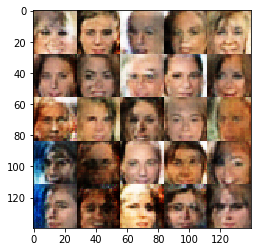

Epoch 1/1 - Batch 1410/202599:  Discriminator Loss: 1.2595 Generator Loss: 0.6897
Epoch 1/1 - Batch 1420/202599:  Discriminator Loss: 0.8872 Generator Loss: 1.5021
Epoch 1/1 - Batch 1430/202599:  Discriminator Loss: 1.5221 Generator Loss: 0.5093
Epoch 1/1 - Batch 1440/202599:  Discriminator Loss: 1.1692 Generator Loss: 0.9958
Epoch 1/1 - Batch 1450/202599:  Discriminator Loss: 1.3511 Generator Loss: 0.7125
Epoch 1/1 - Batch 1460/202599:  Discriminator Loss: 1.0502 Generator Loss: 0.9119
Epoch 1/1 - Batch 1470/202599:  Discriminator Loss: 1.2578 Generator Loss: 0.8508
Epoch 1/1 - Batch 1480/202599:  Discriminator Loss: 1.1836 Generator Loss: 0.7293
Epoch 1/1 - Batch 1490/202599:  Discriminator Loss: 1.0969 Generator Loss: 1.0355
Epoch 1/1 - Batch 1500/202599:  Discriminator Loss: 0.7592 Generator Loss: 2.2813


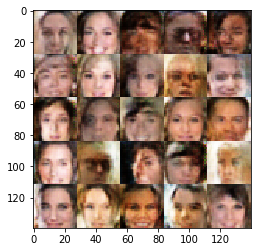

Epoch 1/1 - Batch 1510/202599:  Discriminator Loss: 1.1862 Generator Loss: 0.7369
Epoch 1/1 - Batch 1520/202599:  Discriminator Loss: 1.0683 Generator Loss: 0.9030
Epoch 1/1 - Batch 1530/202599:  Discriminator Loss: 1.4839 Generator Loss: 1.1792
Epoch 1/1 - Batch 1540/202599:  Discriminator Loss: 1.6213 Generator Loss: 1.5148
Epoch 1/1 - Batch 1550/202599:  Discriminator Loss: 1.3723 Generator Loss: 0.8156
Epoch 1/1 - Batch 1560/202599:  Discriminator Loss: 1.2910 Generator Loss: 0.7776
Epoch 1/1 - Batch 1570/202599:  Discriminator Loss: 1.4022 Generator Loss: 1.1378
Epoch 1/1 - Batch 1580/202599:  Discriminator Loss: 1.3984 Generator Loss: 0.6156
Epoch 1/1 - Batch 1590/202599:  Discriminator Loss: 1.1672 Generator Loss: 0.9464
Epoch 1/1 - Batch 1600/202599:  Discriminator Loss: 1.4912 Generator Loss: 0.4791


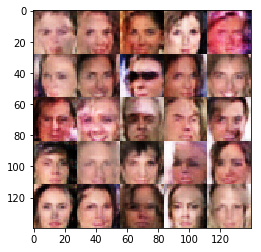

Epoch 1/1 - Batch 1610/202599:  Discriminator Loss: 1.1854 Generator Loss: 1.1055
Epoch 1/1 - Batch 1620/202599:  Discriminator Loss: 1.3827 Generator Loss: 0.5716
Epoch 1/1 - Batch 1630/202599:  Discriminator Loss: 1.5162 Generator Loss: 1.6789
Epoch 1/1 - Batch 1640/202599:  Discriminator Loss: 1.3070 Generator Loss: 0.9955
Epoch 1/1 - Batch 1650/202599:  Discriminator Loss: 1.8130 Generator Loss: 0.2947
Epoch 1/1 - Batch 1660/202599:  Discriminator Loss: 1.2311 Generator Loss: 0.8445
Epoch 1/1 - Batch 1670/202599:  Discriminator Loss: 1.3857 Generator Loss: 0.6360
Epoch 1/1 - Batch 1680/202599:  Discriminator Loss: 1.3568 Generator Loss: 0.6269
Epoch 1/1 - Batch 1690/202599:  Discriminator Loss: 1.2341 Generator Loss: 0.7527
Epoch 1/1 - Batch 1700/202599:  Discriminator Loss: 1.2864 Generator Loss: 0.6432


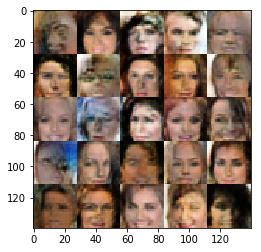

Epoch 1/1 - Batch 1710/202599:  Discriminator Loss: 1.5930 Generator Loss: 0.4264
Epoch 1/1 - Batch 1720/202599:  Discriminator Loss: 1.2767 Generator Loss: 0.6510
Epoch 1/1 - Batch 1730/202599:  Discriminator Loss: 1.1776 Generator Loss: 0.7065
Epoch 1/1 - Batch 1740/202599:  Discriminator Loss: 2.0339 Generator Loss: 1.8480
Epoch 1/1 - Batch 1750/202599:  Discriminator Loss: 1.3935 Generator Loss: 0.6167
Epoch 1/1 - Batch 1760/202599:  Discriminator Loss: 1.4450 Generator Loss: 0.6386
Epoch 1/1 - Batch 1770/202599:  Discriminator Loss: 1.1650 Generator Loss: 0.6935
Epoch 1/1 - Batch 1780/202599:  Discriminator Loss: 1.5773 Generator Loss: 0.4181
Epoch 1/1 - Batch 1790/202599:  Discriminator Loss: 1.5334 Generator Loss: 0.5403
Epoch 1/1 - Batch 1800/202599:  Discriminator Loss: 1.4246 Generator Loss: 0.4798


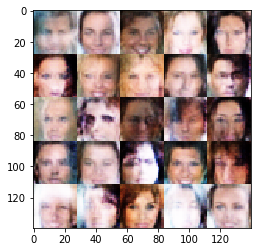

Epoch 1/1 - Batch 1810/202599:  Discriminator Loss: 1.3112 Generator Loss: 0.9705
Epoch 1/1 - Batch 1820/202599:  Discriminator Loss: 1.3279 Generator Loss: 0.6260
Epoch 1/1 - Batch 1830/202599:  Discriminator Loss: 1.5851 Generator Loss: 0.4823
Epoch 1/1 - Batch 1840/202599:  Discriminator Loss: 1.1088 Generator Loss: 1.0293
Epoch 1/1 - Batch 1850/202599:  Discriminator Loss: 1.3709 Generator Loss: 0.6573
Epoch 1/1 - Batch 1860/202599:  Discriminator Loss: 1.0182 Generator Loss: 0.8779
Epoch 1/1 - Batch 1870/202599:  Discriminator Loss: 1.3498 Generator Loss: 0.9096
Epoch 1/1 - Batch 1880/202599:  Discriminator Loss: 1.4362 Generator Loss: 0.6010
Epoch 1/1 - Batch 1890/202599:  Discriminator Loss: 1.3671 Generator Loss: 0.8346
Epoch 1/1 - Batch 1900/202599:  Discriminator Loss: 1.1678 Generator Loss: 0.9704


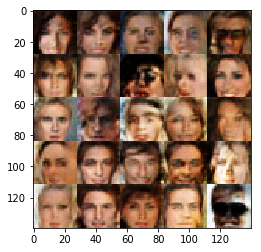

Epoch 1/1 - Batch 1910/202599:  Discriminator Loss: 1.2451 Generator Loss: 0.9280
Epoch 1/1 - Batch 1920/202599:  Discriminator Loss: 1.3342 Generator Loss: 0.7233
Epoch 1/1 - Batch 1930/202599:  Discriminator Loss: 1.1741 Generator Loss: 0.8289
Epoch 1/1 - Batch 1940/202599:  Discriminator Loss: 1.2532 Generator Loss: 0.7230
Epoch 1/1 - Batch 1950/202599:  Discriminator Loss: 1.1674 Generator Loss: 0.8173
Epoch 1/1 - Batch 1960/202599:  Discriminator Loss: 1.2826 Generator Loss: 0.6670
Epoch 1/1 - Batch 1970/202599:  Discriminator Loss: 1.3609 Generator Loss: 0.9255
Epoch 1/1 - Batch 1980/202599:  Discriminator Loss: 1.5124 Generator Loss: 0.5366
Epoch 1/1 - Batch 1990/202599:  Discriminator Loss: 1.4067 Generator Loss: 0.5618
Epoch 1/1 - Batch 2000/202599:  Discriminator Loss: 1.2714 Generator Loss: 0.6891


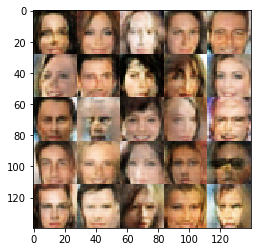

Epoch 1/1 - Batch 2010/202599:  Discriminator Loss: 0.9522 Generator Loss: 1.2579
Epoch 1/1 - Batch 2020/202599:  Discriminator Loss: 1.2596 Generator Loss: 0.7861
Epoch 1/1 - Batch 2030/202599:  Discriminator Loss: 1.1404 Generator Loss: 0.9543
Epoch 1/1 - Batch 2040/202599:  Discriminator Loss: 1.2459 Generator Loss: 0.8743
Epoch 1/1 - Batch 2050/202599:  Discriminator Loss: 1.3220 Generator Loss: 0.6454
Epoch 1/1 - Batch 2060/202599:  Discriminator Loss: 1.3102 Generator Loss: 0.7793
Epoch 1/1 - Batch 2070/202599:  Discriminator Loss: 1.4131 Generator Loss: 1.4373
Epoch 1/1 - Batch 2080/202599:  Discriminator Loss: 1.4044 Generator Loss: 0.4950
Epoch 1/1 - Batch 2090/202599:  Discriminator Loss: 1.4982 Generator Loss: 0.4932
Epoch 1/1 - Batch 2100/202599:  Discriminator Loss: 1.3742 Generator Loss: 0.6099


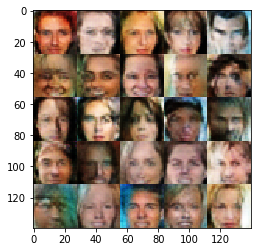

Epoch 1/1 - Batch 2110/202599:  Discriminator Loss: 1.3849 Generator Loss: 0.7176
Epoch 1/1 - Batch 2120/202599:  Discriminator Loss: 1.4400 Generator Loss: 0.5628
Epoch 1/1 - Batch 2130/202599:  Discriminator Loss: 1.1827 Generator Loss: 1.0000
Epoch 1/1 - Batch 2140/202599:  Discriminator Loss: 1.5905 Generator Loss: 0.3867
Epoch 1/1 - Batch 2150/202599:  Discriminator Loss: 1.1834 Generator Loss: 0.8851
Epoch 1/1 - Batch 2160/202599:  Discriminator Loss: 1.3737 Generator Loss: 0.5614
Epoch 1/1 - Batch 2170/202599:  Discriminator Loss: 1.2240 Generator Loss: 1.0683
Epoch 1/1 - Batch 2180/202599:  Discriminator Loss: 1.3840 Generator Loss: 0.6328
Epoch 1/1 - Batch 2190/202599:  Discriminator Loss: 1.3726 Generator Loss: 0.5784
Epoch 1/1 - Batch 2200/202599:  Discriminator Loss: 1.3139 Generator Loss: 1.4783


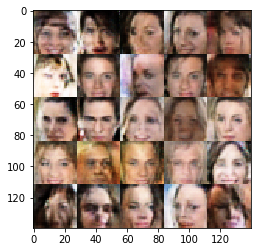

Epoch 1/1 - Batch 2210/202599:  Discriminator Loss: 1.4122 Generator Loss: 0.6218
Epoch 1/1 - Batch 2220/202599:  Discriminator Loss: 1.1984 Generator Loss: 0.8822
Epoch 1/1 - Batch 2230/202599:  Discriminator Loss: 1.2766 Generator Loss: 0.7905
Epoch 1/1 - Batch 2240/202599:  Discriminator Loss: 1.3570 Generator Loss: 0.6672
Epoch 1/1 - Batch 2250/202599:  Discriminator Loss: 1.3545 Generator Loss: 0.7837
Epoch 1/1 - Batch 2260/202599:  Discriminator Loss: 1.5092 Generator Loss: 0.5706
Epoch 1/1 - Batch 2270/202599:  Discriminator Loss: 1.3526 Generator Loss: 0.5686
Epoch 1/1 - Batch 2280/202599:  Discriminator Loss: 1.1972 Generator Loss: 0.7694
Epoch 1/1 - Batch 2290/202599:  Discriminator Loss: 1.2915 Generator Loss: 0.8393
Epoch 1/1 - Batch 2300/202599:  Discriminator Loss: 1.4075 Generator Loss: 0.6424


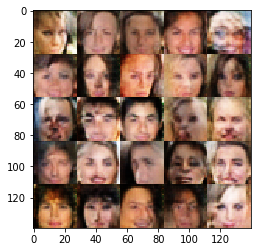

Epoch 1/1 - Batch 2310/202599:  Discriminator Loss: 1.2712 Generator Loss: 0.7734
Epoch 1/1 - Batch 2320/202599:  Discriminator Loss: 1.4126 Generator Loss: 0.5695
Epoch 1/1 - Batch 2330/202599:  Discriminator Loss: 1.2579 Generator Loss: 0.8674
Epoch 1/1 - Batch 2340/202599:  Discriminator Loss: 1.2126 Generator Loss: 1.0188
Epoch 1/1 - Batch 2350/202599:  Discriminator Loss: 1.3138 Generator Loss: 0.7248
Epoch 1/1 - Batch 2360/202599:  Discriminator Loss: 1.3515 Generator Loss: 0.6046
Epoch 1/1 - Batch 2370/202599:  Discriminator Loss: 1.1385 Generator Loss: 0.8127
Epoch 1/1 - Batch 2380/202599:  Discriminator Loss: 1.7382 Generator Loss: 0.3102
Epoch 1/1 - Batch 2390/202599:  Discriminator Loss: 1.3573 Generator Loss: 0.6097
Epoch 1/1 - Batch 2400/202599:  Discriminator Loss: 1.4676 Generator Loss: 0.6995


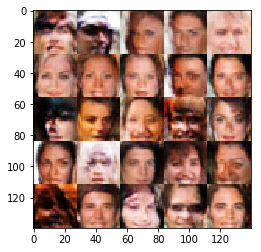

Epoch 1/1 - Batch 2410/202599:  Discriminator Loss: 1.2291 Generator Loss: 0.6646
Epoch 1/1 - Batch 2420/202599:  Discriminator Loss: 1.0496 Generator Loss: 1.1092
Epoch 1/1 - Batch 2430/202599:  Discriminator Loss: 1.3991 Generator Loss: 0.5080
Epoch 1/1 - Batch 2440/202599:  Discriminator Loss: 1.3973 Generator Loss: 0.5636
Epoch 1/1 - Batch 2450/202599:  Discriminator Loss: 1.3772 Generator Loss: 0.7726
Epoch 1/1 - Batch 2460/202599:  Discriminator Loss: 1.2658 Generator Loss: 0.7981
Epoch 1/1 - Batch 2470/202599:  Discriminator Loss: 1.4112 Generator Loss: 0.5315
Epoch 1/1 - Batch 2480/202599:  Discriminator Loss: 1.8072 Generator Loss: 0.3417
Epoch 1/1 - Batch 2490/202599:  Discriminator Loss: 1.4930 Generator Loss: 0.4728
Epoch 1/1 - Batch 2500/202599:  Discriminator Loss: 1.1430 Generator Loss: 0.9362


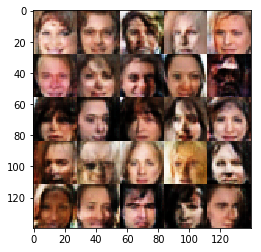

Epoch 1/1 - Batch 2510/202599:  Discriminator Loss: 1.2507 Generator Loss: 0.7270
Epoch 1/1 - Batch 2520/202599:  Discriminator Loss: 1.2900 Generator Loss: 0.9612
Epoch 1/1 - Batch 2530/202599:  Discriminator Loss: 1.4538 Generator Loss: 0.5839
Epoch 1/1 - Batch 2540/202599:  Discriminator Loss: 1.2157 Generator Loss: 0.9710
Epoch 1/1 - Batch 2550/202599:  Discriminator Loss: 1.3192 Generator Loss: 0.6638
Epoch 1/1 - Batch 2560/202599:  Discriminator Loss: 1.2413 Generator Loss: 1.2066
Epoch 1/1 - Batch 2570/202599:  Discriminator Loss: 1.3592 Generator Loss: 0.7029
Epoch 1/1 - Batch 2580/202599:  Discriminator Loss: 1.2304 Generator Loss: 0.7058
Epoch 1/1 - Batch 2590/202599:  Discriminator Loss: 1.3930 Generator Loss: 0.6914
Epoch 1/1 - Batch 2600/202599:  Discriminator Loss: 1.2362 Generator Loss: 0.6714


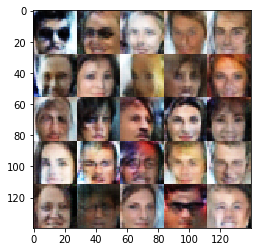

Epoch 1/1 - Batch 2610/202599:  Discriminator Loss: 1.5669 Generator Loss: 0.5342
Epoch 1/1 - Batch 2620/202599:  Discriminator Loss: 1.3086 Generator Loss: 0.6010
Epoch 1/1 - Batch 2630/202599:  Discriminator Loss: 1.3528 Generator Loss: 0.6171
Epoch 1/1 - Batch 2640/202599:  Discriminator Loss: 1.3504 Generator Loss: 0.6993
Epoch 1/1 - Batch 2650/202599:  Discriminator Loss: 1.6120 Generator Loss: 0.4036
Epoch 1/1 - Batch 2660/202599:  Discriminator Loss: 1.2230 Generator Loss: 0.7640
Epoch 1/1 - Batch 2670/202599:  Discriminator Loss: 1.3381 Generator Loss: 0.8936
Epoch 1/1 - Batch 2680/202599:  Discriminator Loss: 1.3151 Generator Loss: 0.7309
Epoch 1/1 - Batch 2690/202599:  Discriminator Loss: 1.3941 Generator Loss: 0.5950
Epoch 1/1 - Batch 2700/202599:  Discriminator Loss: 1.3608 Generator Loss: 0.6022


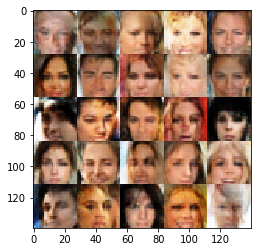

Epoch 1/1 - Batch 2710/202599:  Discriminator Loss: 1.3373 Generator Loss: 0.9374
Epoch 1/1 - Batch 2720/202599:  Discriminator Loss: 1.1949 Generator Loss: 0.8781
Epoch 1/1 - Batch 2730/202599:  Discriminator Loss: 1.1529 Generator Loss: 0.9670
Epoch 1/1 - Batch 2740/202599:  Discriminator Loss: 1.3262 Generator Loss: 0.7098
Epoch 1/1 - Batch 2750/202599:  Discriminator Loss: 1.2043 Generator Loss: 0.7464
Epoch 1/1 - Batch 2760/202599:  Discriminator Loss: 1.5729 Generator Loss: 0.4291
Epoch 1/1 - Batch 2770/202599:  Discriminator Loss: 1.1806 Generator Loss: 0.9306
Epoch 1/1 - Batch 2780/202599:  Discriminator Loss: 1.3963 Generator Loss: 0.5218
Epoch 1/1 - Batch 2790/202599:  Discriminator Loss: 1.2725 Generator Loss: 0.7775
Epoch 1/1 - Batch 2800/202599:  Discriminator Loss: 1.4724 Generator Loss: 0.4776


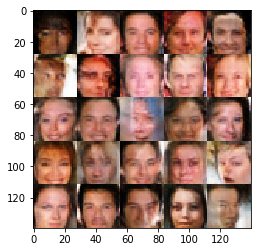

Epoch 1/1 - Batch 2810/202599:  Discriminator Loss: 1.3895 Generator Loss: 0.5425
Epoch 1/1 - Batch 2820/202599:  Discriminator Loss: 1.2964 Generator Loss: 0.6351
Epoch 1/1 - Batch 2830/202599:  Discriminator Loss: 1.2286 Generator Loss: 0.6945
Epoch 1/1 - Batch 2840/202599:  Discriminator Loss: 1.1472 Generator Loss: 0.9599
Epoch 1/1 - Batch 2850/202599:  Discriminator Loss: 1.3855 Generator Loss: 0.6540
Epoch 1/1 - Batch 2860/202599:  Discriminator Loss: 1.1120 Generator Loss: 0.9307
Epoch 1/1 - Batch 2870/202599:  Discriminator Loss: 1.3800 Generator Loss: 0.8301
Epoch 1/1 - Batch 2880/202599:  Discriminator Loss: 1.0995 Generator Loss: 0.7478
Epoch 1/1 - Batch 2890/202599:  Discriminator Loss: 1.0680 Generator Loss: 1.0971
Epoch 1/1 - Batch 2900/202599:  Discriminator Loss: 1.4028 Generator Loss: 0.8454


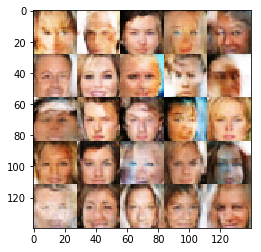

Epoch 1/1 - Batch 2910/202599:  Discriminator Loss: 1.3370 Generator Loss: 0.7570
Epoch 1/1 - Batch 2920/202599:  Discriminator Loss: 1.2804 Generator Loss: 0.7543
Epoch 1/1 - Batch 2930/202599:  Discriminator Loss: 1.2722 Generator Loss: 0.6551
Epoch 1/1 - Batch 2940/202599:  Discriminator Loss: 1.4493 Generator Loss: 0.6931
Epoch 1/1 - Batch 2950/202599:  Discriminator Loss: 1.6369 Generator Loss: 0.6491
Epoch 1/1 - Batch 2960/202599:  Discriminator Loss: 1.2852 Generator Loss: 0.6793
Epoch 1/1 - Batch 2970/202599:  Discriminator Loss: 1.2656 Generator Loss: 0.7426
Epoch 1/1 - Batch 2980/202599:  Discriminator Loss: 1.3502 Generator Loss: 0.7474
Epoch 1/1 - Batch 2990/202599:  Discriminator Loss: 1.2626 Generator Loss: 0.7433
Epoch 1/1 - Batch 3000/202599:  Discriminator Loss: 1.3421 Generator Loss: 0.6358


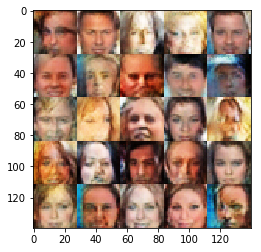

Epoch 1/1 - Batch 3010/202599:  Discriminator Loss: 1.2592 Generator Loss: 0.6811
Epoch 1/1 - Batch 3020/202599:  Discriminator Loss: 1.2001 Generator Loss: 0.8057
Epoch 1/1 - Batch 3030/202599:  Discriminator Loss: 1.4051 Generator Loss: 0.5238
Epoch 1/1 - Batch 3040/202599:  Discriminator Loss: 1.3481 Generator Loss: 0.7737
Epoch 1/1 - Batch 3050/202599:  Discriminator Loss: 1.3373 Generator Loss: 0.7670
Epoch 1/1 - Batch 3060/202599:  Discriminator Loss: 1.5031 Generator Loss: 0.4798
Epoch 1/1 - Batch 3070/202599:  Discriminator Loss: 1.3348 Generator Loss: 0.7045
Epoch 1/1 - Batch 3080/202599:  Discriminator Loss: 1.2757 Generator Loss: 0.9470
Epoch 1/1 - Batch 3090/202599:  Discriminator Loss: 1.3731 Generator Loss: 0.5700
Epoch 1/1 - Batch 3100/202599:  Discriminator Loss: 1.4753 Generator Loss: 0.5667


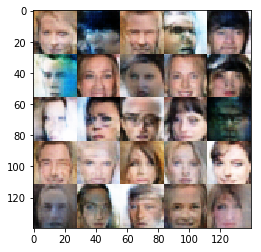

Epoch 1/1 - Batch 3110/202599:  Discriminator Loss: 1.4252 Generator Loss: 0.7140
Epoch 1/1 - Batch 3120/202599:  Discriminator Loss: 1.3399 Generator Loss: 0.6763
Epoch 1/1 - Batch 3130/202599:  Discriminator Loss: 1.4282 Generator Loss: 0.5038
Epoch 1/1 - Batch 3140/202599:  Discriminator Loss: 1.2505 Generator Loss: 0.7573
Epoch 1/1 - Batch 3150/202599:  Discriminator Loss: 1.3847 Generator Loss: 0.5629
Epoch 1/1 - Batch 3160/202599:  Discriminator Loss: 1.3409 Generator Loss: 0.5837
Epoch 1/1 - Batch 10/202599:  Discriminator Loss: 1.5298 Generator Loss: 0.4393
Epoch 1/1 - Batch 20/202599:  Discriminator Loss: 1.2810 Generator Loss: 0.7239
Epoch 1/1 - Batch 30/202599:  Discriminator Loss: 1.2476 Generator Loss: 0.9261
Epoch 1/1 - Batch 40/202599:  Discriminator Loss: 1.1694 Generator Loss: 0.8912
Epoch 1/1 - Batch 50/202599:  Discriminator Loss: 1.2667 Generator Loss: 0.9556
Epoch 1/1 - Batch 60/202599:  Discriminator Loss: 1.0331 Generator Loss: 0.9121
Epoch 1/1 - Batch 70/202599:

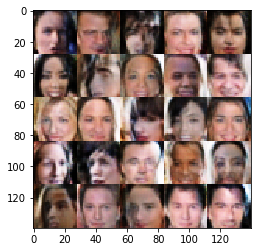

Epoch 1/1 - Batch 110/202599:  Discriminator Loss: 1.2775 Generator Loss: 0.6026
Epoch 1/1 - Batch 120/202599:  Discriminator Loss: 1.3733 Generator Loss: 0.6683
Epoch 1/1 - Batch 130/202599:  Discriminator Loss: 1.2868 Generator Loss: 0.9410
Epoch 1/1 - Batch 140/202599:  Discriminator Loss: 1.4392 Generator Loss: 0.6048
Epoch 1/1 - Batch 150/202599:  Discriminator Loss: 1.3944 Generator Loss: 0.6168
Epoch 1/1 - Batch 160/202599:  Discriminator Loss: 1.3712 Generator Loss: 0.5233
Epoch 1/1 - Batch 170/202599:  Discriminator Loss: 1.3371 Generator Loss: 0.6347
Epoch 1/1 - Batch 180/202599:  Discriminator Loss: 1.2096 Generator Loss: 0.8753
Epoch 1/1 - Batch 190/202599:  Discriminator Loss: 1.1794 Generator Loss: 0.9017
Epoch 1/1 - Batch 200/202599:  Discriminator Loss: 1.0137 Generator Loss: 1.0454


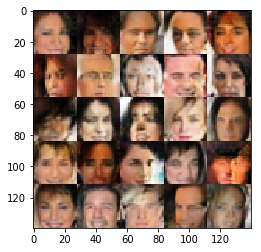

Epoch 1/1 - Batch 210/202599:  Discriminator Loss: 1.2897 Generator Loss: 0.6436
Epoch 1/1 - Batch 220/202599:  Discriminator Loss: 1.1998 Generator Loss: 1.1272
Epoch 1/1 - Batch 230/202599:  Discriminator Loss: 1.1863 Generator Loss: 0.6699
Epoch 1/1 - Batch 240/202599:  Discriminator Loss: 1.3237 Generator Loss: 0.7361
Epoch 1/1 - Batch 250/202599:  Discriminator Loss: 0.9884 Generator Loss: 1.3287
Epoch 1/1 - Batch 260/202599:  Discriminator Loss: 1.2753 Generator Loss: 0.7928
Epoch 1/1 - Batch 270/202599:  Discriminator Loss: 1.3216 Generator Loss: 1.0080
Epoch 1/1 - Batch 280/202599:  Discriminator Loss: 1.3653 Generator Loss: 0.6394
Epoch 1/1 - Batch 290/202599:  Discriminator Loss: 1.5854 Generator Loss: 0.4099
Epoch 1/1 - Batch 300/202599:  Discriminator Loss: 1.3196 Generator Loss: 1.0177


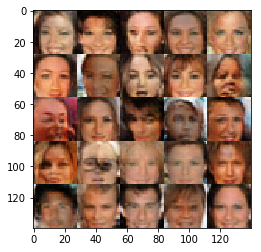

Epoch 1/1 - Batch 310/202599:  Discriminator Loss: 1.0646 Generator Loss: 1.2985
Epoch 1/1 - Batch 320/202599:  Discriminator Loss: 1.3071 Generator Loss: 1.2321
Epoch 1/1 - Batch 330/202599:  Discriminator Loss: 1.5190 Generator Loss: 0.4784
Epoch 1/1 - Batch 340/202599:  Discriminator Loss: 1.2469 Generator Loss: 0.6847
Epoch 1/1 - Batch 350/202599:  Discriminator Loss: 1.4878 Generator Loss: 1.2775
Epoch 1/1 - Batch 360/202599:  Discriminator Loss: 1.4593 Generator Loss: 0.5090
Epoch 1/1 - Batch 370/202599:  Discriminator Loss: 1.3312 Generator Loss: 0.7144
Epoch 1/1 - Batch 380/202599:  Discriminator Loss: 1.4778 Generator Loss: 0.5147
Epoch 1/1 - Batch 390/202599:  Discriminator Loss: 1.3125 Generator Loss: 0.7201
Epoch 1/1 - Batch 400/202599:  Discriminator Loss: 1.4358 Generator Loss: 0.6648


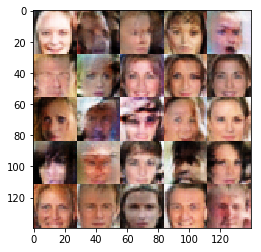

Epoch 1/1 - Batch 410/202599:  Discriminator Loss: 1.3017 Generator Loss: 0.7255
Epoch 1/1 - Batch 420/202599:  Discriminator Loss: 1.3372 Generator Loss: 0.6255
Epoch 1/1 - Batch 430/202599:  Discriminator Loss: 1.3531 Generator Loss: 0.6330
Epoch 1/1 - Batch 440/202599:  Discriminator Loss: 1.3737 Generator Loss: 0.6846
Epoch 1/1 - Batch 450/202599:  Discriminator Loss: 1.4586 Generator Loss: 0.5037
Epoch 1/1 - Batch 460/202599:  Discriminator Loss: 1.3413 Generator Loss: 0.7809
Epoch 1/1 - Batch 470/202599:  Discriminator Loss: 1.3942 Generator Loss: 0.6334
Epoch 1/1 - Batch 480/202599:  Discriminator Loss: 1.2735 Generator Loss: 0.7910
Epoch 1/1 - Batch 490/202599:  Discriminator Loss: 1.2920 Generator Loss: 0.9483
Epoch 1/1 - Batch 500/202599:  Discriminator Loss: 1.2090 Generator Loss: 0.7127


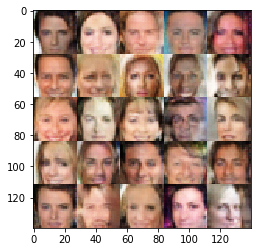

Epoch 1/1 - Batch 510/202599:  Discriminator Loss: 1.5238 Generator Loss: 0.4950
Epoch 1/1 - Batch 520/202599:  Discriminator Loss: 1.2906 Generator Loss: 0.6722
Epoch 1/1 - Batch 530/202599:  Discriminator Loss: 1.5344 Generator Loss: 1.1754
Epoch 1/1 - Batch 540/202599:  Discriminator Loss: 1.2431 Generator Loss: 0.6443
Epoch 1/1 - Batch 550/202599:  Discriminator Loss: 1.3194 Generator Loss: 0.6921
Epoch 1/1 - Batch 560/202599:  Discriminator Loss: 1.2890 Generator Loss: 0.7736
Epoch 1/1 - Batch 570/202599:  Discriminator Loss: 1.2444 Generator Loss: 0.8562
Epoch 1/1 - Batch 580/202599:  Discriminator Loss: 1.4005 Generator Loss: 0.5694
Epoch 1/1 - Batch 590/202599:  Discriminator Loss: 1.3027 Generator Loss: 0.6958
Epoch 1/1 - Batch 600/202599:  Discriminator Loss: 1.1091 Generator Loss: 0.9342


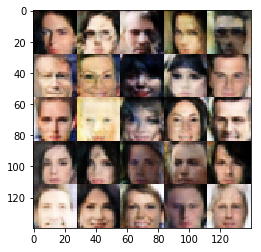

Epoch 1/1 - Batch 610/202599:  Discriminator Loss: 1.1854 Generator Loss: 0.9715
Epoch 1/1 - Batch 620/202599:  Discriminator Loss: 1.3098 Generator Loss: 0.6374
Epoch 1/1 - Batch 630/202599:  Discriminator Loss: 1.2801 Generator Loss: 0.8219
Epoch 1/1 - Batch 640/202599:  Discriminator Loss: 1.3475 Generator Loss: 0.5653
Epoch 1/1 - Batch 650/202599:  Discriminator Loss: 1.2797 Generator Loss: 0.7175
Epoch 1/1 - Batch 660/202599:  Discriminator Loss: 1.4856 Generator Loss: 0.5049
Epoch 1/1 - Batch 670/202599:  Discriminator Loss: 1.2684 Generator Loss: 0.8113
Epoch 1/1 - Batch 680/202599:  Discriminator Loss: 1.3518 Generator Loss: 0.6260
Epoch 1/1 - Batch 690/202599:  Discriminator Loss: 1.2216 Generator Loss: 0.9121
Epoch 1/1 - Batch 700/202599:  Discriminator Loss: 1.3683 Generator Loss: 0.5310


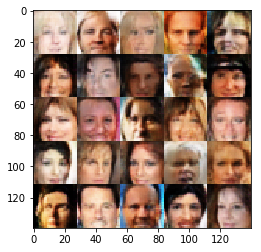

Epoch 1/1 - Batch 710/202599:  Discriminator Loss: 1.1204 Generator Loss: 0.7583
Epoch 1/1 - Batch 720/202599:  Discriminator Loss: 1.4399 Generator Loss: 0.5235
Epoch 1/1 - Batch 730/202599:  Discriminator Loss: 1.3403 Generator Loss: 0.6454
Epoch 1/1 - Batch 740/202599:  Discriminator Loss: 1.2289 Generator Loss: 0.9110
Epoch 1/1 - Batch 750/202599:  Discriminator Loss: 1.2425 Generator Loss: 0.8131
Epoch 1/1 - Batch 760/202599:  Discriminator Loss: 1.3647 Generator Loss: 0.7032
Epoch 1/1 - Batch 770/202599:  Discriminator Loss: 1.1891 Generator Loss: 0.9001
Epoch 1/1 - Batch 780/202599:  Discriminator Loss: 1.4670 Generator Loss: 0.4803
Epoch 1/1 - Batch 790/202599:  Discriminator Loss: 1.3808 Generator Loss: 0.6948
Epoch 1/1 - Batch 800/202599:  Discriminator Loss: 1.3665 Generator Loss: 0.6102


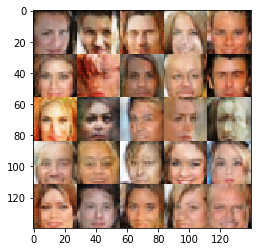

Epoch 1/1 - Batch 810/202599:  Discriminator Loss: 1.2874 Generator Loss: 0.9705
Epoch 1/1 - Batch 820/202599:  Discriminator Loss: 1.2968 Generator Loss: 0.7586
Epoch 1/1 - Batch 830/202599:  Discriminator Loss: 1.4513 Generator Loss: 0.5697
Epoch 1/1 - Batch 840/202599:  Discriminator Loss: 1.3773 Generator Loss: 0.6414
Epoch 1/1 - Batch 850/202599:  Discriminator Loss: 1.1959 Generator Loss: 0.7470
Epoch 1/1 - Batch 860/202599:  Discriminator Loss: 1.3188 Generator Loss: 0.7247
Epoch 1/1 - Batch 870/202599:  Discriminator Loss: 1.4256 Generator Loss: 0.5913
Epoch 1/1 - Batch 880/202599:  Discriminator Loss: 1.2893 Generator Loss: 0.6473
Epoch 1/1 - Batch 890/202599:  Discriminator Loss: 1.3411 Generator Loss: 0.6861
Epoch 1/1 - Batch 900/202599:  Discriminator Loss: 1.4732 Generator Loss: 0.5512


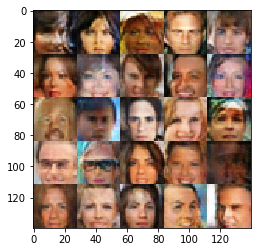

Epoch 1/1 - Batch 910/202599:  Discriminator Loss: 1.2372 Generator Loss: 0.7935
Epoch 1/1 - Batch 920/202599:  Discriminator Loss: 1.3137 Generator Loss: 0.6162
Epoch 1/1 - Batch 930/202599:  Discriminator Loss: 1.3874 Generator Loss: 0.5799
Epoch 1/1 - Batch 940/202599:  Discriminator Loss: 1.2697 Generator Loss: 0.8347
Epoch 1/1 - Batch 950/202599:  Discriminator Loss: 1.3114 Generator Loss: 0.6646
Epoch 1/1 - Batch 960/202599:  Discriminator Loss: 1.5029 Generator Loss: 0.4725
Epoch 1/1 - Batch 970/202599:  Discriminator Loss: 1.2085 Generator Loss: 0.8125
Epoch 1/1 - Batch 980/202599:  Discriminator Loss: 1.3623 Generator Loss: 0.6602
Epoch 1/1 - Batch 990/202599:  Discriminator Loss: 1.4665 Generator Loss: 0.4967
Epoch 1/1 - Batch 1000/202599:  Discriminator Loss: 1.3380 Generator Loss: 0.6680


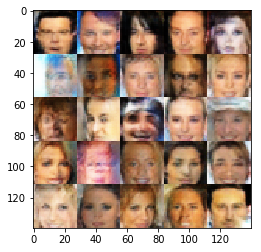

Epoch 1/1 - Batch 1010/202599:  Discriminator Loss: 1.4069 Generator Loss: 0.5705
Epoch 1/1 - Batch 1020/202599:  Discriminator Loss: 1.4320 Generator Loss: 0.5426
Epoch 1/1 - Batch 1030/202599:  Discriminator Loss: 1.3616 Generator Loss: 0.9398
Epoch 1/1 - Batch 1040/202599:  Discriminator Loss: 1.2412 Generator Loss: 0.7979
Epoch 1/1 - Batch 1050/202599:  Discriminator Loss: 1.4783 Generator Loss: 0.5078
Epoch 1/1 - Batch 1060/202599:  Discriminator Loss: 1.2740 Generator Loss: 0.7774
Epoch 1/1 - Batch 1070/202599:  Discriminator Loss: 1.3192 Generator Loss: 0.6598
Epoch 1/1 - Batch 1080/202599:  Discriminator Loss: 1.3136 Generator Loss: 0.8248
Epoch 1/1 - Batch 1090/202599:  Discriminator Loss: 1.1500 Generator Loss: 0.8597
Epoch 1/1 - Batch 1100/202599:  Discriminator Loss: 1.7479 Generator Loss: 0.3533


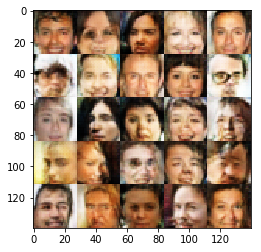

Epoch 1/1 - Batch 1110/202599:  Discriminator Loss: 1.4799 Generator Loss: 0.7063
Epoch 1/1 - Batch 1120/202599:  Discriminator Loss: 1.3300 Generator Loss: 0.6230
Epoch 1/1 - Batch 1130/202599:  Discriminator Loss: 1.3408 Generator Loss: 0.6156
Epoch 1/1 - Batch 1140/202599:  Discriminator Loss: 1.4477 Generator Loss: 0.5624
Epoch 1/1 - Batch 1150/202599:  Discriminator Loss: 1.2492 Generator Loss: 0.9770
Epoch 1/1 - Batch 1160/202599:  Discriminator Loss: 1.4869 Generator Loss: 0.4739
Epoch 1/1 - Batch 1170/202599:  Discriminator Loss: 1.3663 Generator Loss: 0.8382
Epoch 1/1 - Batch 1180/202599:  Discriminator Loss: 1.1755 Generator Loss: 0.8626
Epoch 1/1 - Batch 1190/202599:  Discriminator Loss: 1.4137 Generator Loss: 0.5624
Epoch 1/1 - Batch 1200/202599:  Discriminator Loss: 1.2766 Generator Loss: 0.7167


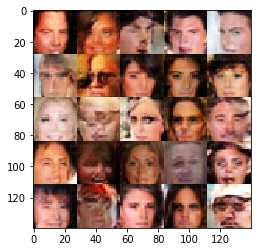

Epoch 1/1 - Batch 1210/202599:  Discriminator Loss: 1.3532 Generator Loss: 0.5518
Epoch 1/1 - Batch 1220/202599:  Discriminator Loss: 1.4178 Generator Loss: 0.6688
Epoch 1/1 - Batch 1230/202599:  Discriminator Loss: 1.4514 Generator Loss: 0.5194
Epoch 1/1 - Batch 1240/202599:  Discriminator Loss: 1.4035 Generator Loss: 0.7560
Epoch 1/1 - Batch 1250/202599:  Discriminator Loss: 1.3354 Generator Loss: 0.7777
Epoch 1/1 - Batch 1260/202599:  Discriminator Loss: 1.3379 Generator Loss: 0.6126
Epoch 1/1 - Batch 1270/202599:  Discriminator Loss: 1.3384 Generator Loss: 0.9003
Epoch 1/1 - Batch 1280/202599:  Discriminator Loss: 1.3706 Generator Loss: 0.6953
Epoch 1/1 - Batch 1290/202599:  Discriminator Loss: 1.5201 Generator Loss: 0.4563
Epoch 1/1 - Batch 1300/202599:  Discriminator Loss: 1.3237 Generator Loss: 0.7822


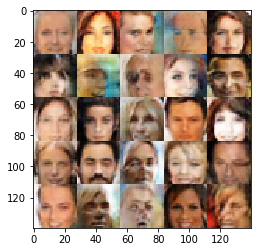

Epoch 1/1 - Batch 1310/202599:  Discriminator Loss: 1.4064 Generator Loss: 0.6682
Epoch 1/1 - Batch 1320/202599:  Discriminator Loss: 1.3477 Generator Loss: 0.8159
Epoch 1/1 - Batch 1330/202599:  Discriminator Loss: 1.3396 Generator Loss: 0.6805
Epoch 1/1 - Batch 1340/202599:  Discriminator Loss: 1.3763 Generator Loss: 0.6362
Epoch 1/1 - Batch 1350/202599:  Discriminator Loss: 1.2017 Generator Loss: 0.7809
Epoch 1/1 - Batch 1360/202599:  Discriminator Loss: 1.2527 Generator Loss: 0.9158
Epoch 1/1 - Batch 1370/202599:  Discriminator Loss: 1.2393 Generator Loss: 0.8973
Epoch 1/1 - Batch 1380/202599:  Discriminator Loss: 1.6269 Generator Loss: 0.4119
Epoch 1/1 - Batch 1390/202599:  Discriminator Loss: 1.2723 Generator Loss: 0.7554
Epoch 1/1 - Batch 1400/202599:  Discriminator Loss: 1.4484 Generator Loss: 0.6702


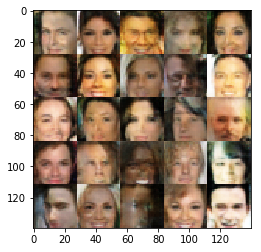

Epoch 1/1 - Batch 1410/202599:  Discriminator Loss: 1.4497 Generator Loss: 0.7342
Epoch 1/1 - Batch 1420/202599:  Discriminator Loss: 1.2962 Generator Loss: 0.6911
Epoch 1/1 - Batch 1430/202599:  Discriminator Loss: 1.4349 Generator Loss: 0.6235
Epoch 1/1 - Batch 1440/202599:  Discriminator Loss: 1.3585 Generator Loss: 0.6446
Epoch 1/1 - Batch 1450/202599:  Discriminator Loss: 1.1847 Generator Loss: 0.8470
Epoch 1/1 - Batch 1460/202599:  Discriminator Loss: 1.4326 Generator Loss: 0.5008
Epoch 1/1 - Batch 1470/202599:  Discriminator Loss: 1.3552 Generator Loss: 0.8997
Epoch 1/1 - Batch 1480/202599:  Discriminator Loss: 1.2900 Generator Loss: 0.6285
Epoch 1/1 - Batch 1490/202599:  Discriminator Loss: 1.2587 Generator Loss: 0.7736
Epoch 1/1 - Batch 1500/202599:  Discriminator Loss: 1.3251 Generator Loss: 0.7893


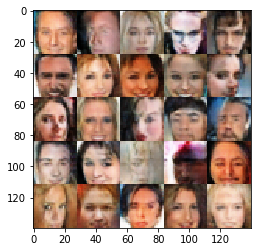

Epoch 1/1 - Batch 1510/202599:  Discriminator Loss: 1.4473 Generator Loss: 0.4780
Epoch 1/1 - Batch 1520/202599:  Discriminator Loss: 1.4337 Generator Loss: 0.4973
Epoch 1/1 - Batch 1530/202599:  Discriminator Loss: 1.2581 Generator Loss: 0.9613
Epoch 1/1 - Batch 1540/202599:  Discriminator Loss: 1.5208 Generator Loss: 0.5095
Epoch 1/1 - Batch 1550/202599:  Discriminator Loss: 1.2591 Generator Loss: 0.9206
Epoch 1/1 - Batch 1560/202599:  Discriminator Loss: 1.3543 Generator Loss: 0.7982
Epoch 1/1 - Batch 1570/202599:  Discriminator Loss: 1.2710 Generator Loss: 0.7117
Epoch 1/1 - Batch 1580/202599:  Discriminator Loss: 1.3581 Generator Loss: 0.6029
Epoch 1/1 - Batch 1590/202599:  Discriminator Loss: 1.3575 Generator Loss: 0.6151
Epoch 1/1 - Batch 1600/202599:  Discriminator Loss: 1.3918 Generator Loss: 0.7387


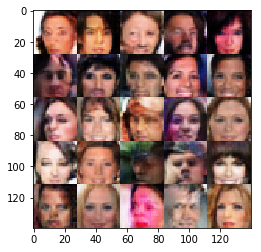

Epoch 1/1 - Batch 1610/202599:  Discriminator Loss: 1.3845 Generator Loss: 0.6260
Epoch 1/1 - Batch 1620/202599:  Discriminator Loss: 1.3893 Generator Loss: 0.6126
Epoch 1/1 - Batch 1630/202599:  Discriminator Loss: 1.3752 Generator Loss: 0.5671
Epoch 1/1 - Batch 1640/202599:  Discriminator Loss: 1.4996 Generator Loss: 0.5631
Epoch 1/1 - Batch 1650/202599:  Discriminator Loss: 1.5910 Generator Loss: 0.4208
Epoch 1/1 - Batch 1660/202599:  Discriminator Loss: 1.3974 Generator Loss: 0.5794
Epoch 1/1 - Batch 1670/202599:  Discriminator Loss: 1.2436 Generator Loss: 0.7630
Epoch 1/1 - Batch 1680/202599:  Discriminator Loss: 1.4958 Generator Loss: 0.5384
Epoch 1/1 - Batch 1690/202599:  Discriminator Loss: 1.2198 Generator Loss: 0.8449
Epoch 1/1 - Batch 1700/202599:  Discriminator Loss: 1.5394 Generator Loss: 0.4653


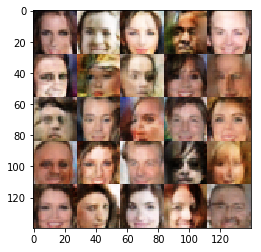

Epoch 1/1 - Batch 1710/202599:  Discriminator Loss: 1.2939 Generator Loss: 0.7049
Epoch 1/1 - Batch 1720/202599:  Discriminator Loss: 1.3048 Generator Loss: 1.0247
Epoch 1/1 - Batch 1730/202599:  Discriminator Loss: 1.3315 Generator Loss: 0.6947
Epoch 1/1 - Batch 1740/202599:  Discriminator Loss: 1.3574 Generator Loss: 0.7826
Epoch 1/1 - Batch 1750/202599:  Discriminator Loss: 1.2825 Generator Loss: 0.7661
Epoch 1/1 - Batch 1760/202599:  Discriminator Loss: 1.4021 Generator Loss: 0.6546
Epoch 1/1 - Batch 1770/202599:  Discriminator Loss: 1.2807 Generator Loss: 0.6127
Epoch 1/1 - Batch 1780/202599:  Discriminator Loss: 1.4137 Generator Loss: 0.5784
Epoch 1/1 - Batch 1790/202599:  Discriminator Loss: 1.5714 Generator Loss: 0.5980
Epoch 1/1 - Batch 1800/202599:  Discriminator Loss: 1.3989 Generator Loss: 0.5372


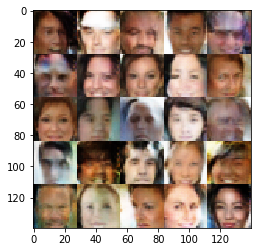

Epoch 1/1 - Batch 1810/202599:  Discriminator Loss: 1.3151 Generator Loss: 0.6739
Epoch 1/1 - Batch 1820/202599:  Discriminator Loss: 1.3254 Generator Loss: 0.7176
Epoch 1/1 - Batch 1830/202599:  Discriminator Loss: 1.5310 Generator Loss: 0.5612
Epoch 1/1 - Batch 1840/202599:  Discriminator Loss: 1.4735 Generator Loss: 0.5226
Epoch 1/1 - Batch 1850/202599:  Discriminator Loss: 1.4575 Generator Loss: 0.6134
Epoch 1/1 - Batch 1860/202599:  Discriminator Loss: 1.4159 Generator Loss: 0.6089
Epoch 1/1 - Batch 1870/202599:  Discriminator Loss: 1.1177 Generator Loss: 1.0833
Epoch 1/1 - Batch 1880/202599:  Discriminator Loss: 1.2901 Generator Loss: 0.6485
Epoch 1/1 - Batch 1890/202599:  Discriminator Loss: 1.2874 Generator Loss: 0.9383
Epoch 1/1 - Batch 1900/202599:  Discriminator Loss: 1.3722 Generator Loss: 0.7234


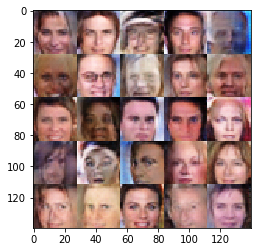

Epoch 1/1 - Batch 1910/202599:  Discriminator Loss: 1.3005 Generator Loss: 0.6927
Epoch 1/1 - Batch 1920/202599:  Discriminator Loss: 1.3173 Generator Loss: 0.7543
Epoch 1/1 - Batch 1930/202599:  Discriminator Loss: 0.9314 Generator Loss: 1.1416
Epoch 1/1 - Batch 1940/202599:  Discriminator Loss: 1.4782 Generator Loss: 0.5139
Epoch 1/1 - Batch 1950/202599:  Discriminator Loss: 1.0962 Generator Loss: 0.9806
Epoch 1/1 - Batch 1960/202599:  Discriminator Loss: 1.4020 Generator Loss: 0.7945
Epoch 1/1 - Batch 1970/202599:  Discriminator Loss: 1.4273 Generator Loss: 0.5745
Epoch 1/1 - Batch 1980/202599:  Discriminator Loss: 1.4259 Generator Loss: 0.5994
Epoch 1/1 - Batch 1990/202599:  Discriminator Loss: 1.3416 Generator Loss: 0.6355
Epoch 1/1 - Batch 2000/202599:  Discriminator Loss: 1.1897 Generator Loss: 1.0332


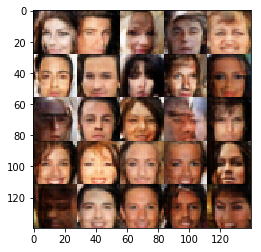

Epoch 1/1 - Batch 2010/202599:  Discriminator Loss: 1.6176 Generator Loss: 0.4815
Epoch 1/1 - Batch 2020/202599:  Discriminator Loss: 1.2900 Generator Loss: 0.6426
Epoch 1/1 - Batch 2030/202599:  Discriminator Loss: 1.4273 Generator Loss: 0.6147
Epoch 1/1 - Batch 2040/202599:  Discriminator Loss: 1.5286 Generator Loss: 0.6987
Epoch 1/1 - Batch 2050/202599:  Discriminator Loss: 1.4011 Generator Loss: 0.6877
Epoch 1/1 - Batch 2060/202599:  Discriminator Loss: 1.3752 Generator Loss: 0.7489
Epoch 1/1 - Batch 2070/202599:  Discriminator Loss: 1.2830 Generator Loss: 0.7968
Epoch 1/1 - Batch 2080/202599:  Discriminator Loss: 1.2515 Generator Loss: 0.8447
Epoch 1/1 - Batch 2090/202599:  Discriminator Loss: 1.3898 Generator Loss: 0.6293
Epoch 1/1 - Batch 2100/202599:  Discriminator Loss: 1.3817 Generator Loss: 0.6173


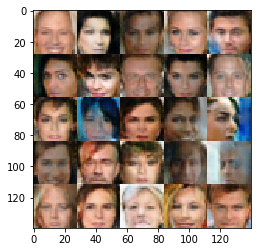

Epoch 1/1 - Batch 2110/202599:  Discriminator Loss: 1.4005 Generator Loss: 0.7279
Epoch 1/1 - Batch 2120/202599:  Discriminator Loss: 1.3316 Generator Loss: 0.7250
Epoch 1/1 - Batch 2130/202599:  Discriminator Loss: 1.1272 Generator Loss: 0.9377
Epoch 1/1 - Batch 2140/202599:  Discriminator Loss: 1.4239 Generator Loss: 0.5983
Epoch 1/1 - Batch 2150/202599:  Discriminator Loss: 1.3679 Generator Loss: 0.6548
Epoch 1/1 - Batch 2160/202599:  Discriminator Loss: 1.2411 Generator Loss: 0.6373
Epoch 1/1 - Batch 2170/202599:  Discriminator Loss: 1.2224 Generator Loss: 0.9233
Epoch 1/1 - Batch 2180/202599:  Discriminator Loss: 1.3571 Generator Loss: 0.6328
Epoch 1/1 - Batch 2190/202599:  Discriminator Loss: 1.6292 Generator Loss: 0.4326
Epoch 1/1 - Batch 2200/202599:  Discriminator Loss: 1.6076 Generator Loss: 1.2822


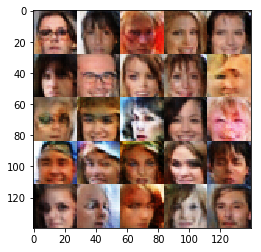

Epoch 1/1 - Batch 2210/202599:  Discriminator Loss: 1.4949 Generator Loss: 0.5902
Epoch 1/1 - Batch 2220/202599:  Discriminator Loss: 1.1476 Generator Loss: 0.8056
Epoch 1/1 - Batch 2230/202599:  Discriminator Loss: 1.8794 Generator Loss: 0.3334
Epoch 1/1 - Batch 2240/202599:  Discriminator Loss: 1.4590 Generator Loss: 0.5517
Epoch 1/1 - Batch 2250/202599:  Discriminator Loss: 1.2626 Generator Loss: 0.7564
Epoch 1/1 - Batch 2260/202599:  Discriminator Loss: 1.3032 Generator Loss: 0.7056
Epoch 1/1 - Batch 2270/202599:  Discriminator Loss: 1.4990 Generator Loss: 0.5311
Epoch 1/1 - Batch 2280/202599:  Discriminator Loss: 1.3819 Generator Loss: 0.7500
Epoch 1/1 - Batch 2290/202599:  Discriminator Loss: 1.3086 Generator Loss: 0.7844
Epoch 1/1 - Batch 2300/202599:  Discriminator Loss: 1.4117 Generator Loss: 0.7109


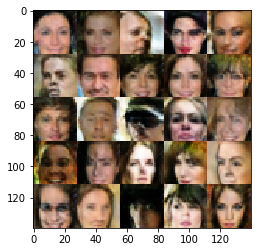

Epoch 1/1 - Batch 2310/202599:  Discriminator Loss: 1.3745 Generator Loss: 0.8333
Epoch 1/1 - Batch 2320/202599:  Discriminator Loss: 1.4726 Generator Loss: 0.6463
Epoch 1/1 - Batch 2330/202599:  Discriminator Loss: 1.3071 Generator Loss: 0.7171
Epoch 1/1 - Batch 2340/202599:  Discriminator Loss: 1.4642 Generator Loss: 0.5705
Epoch 1/1 - Batch 2350/202599:  Discriminator Loss: 1.7133 Generator Loss: 0.5417
Epoch 1/1 - Batch 2360/202599:  Discriminator Loss: 1.3975 Generator Loss: 0.5359
Epoch 1/1 - Batch 2370/202599:  Discriminator Loss: 1.5666 Generator Loss: 0.4724
Epoch 1/1 - Batch 2380/202599:  Discriminator Loss: 1.3474 Generator Loss: 0.6511
Epoch 1/1 - Batch 2390/202599:  Discriminator Loss: 1.5629 Generator Loss: 0.4637
Epoch 1/1 - Batch 2400/202599:  Discriminator Loss: 1.4636 Generator Loss: 0.4790


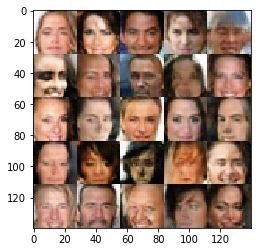

Epoch 1/1 - Batch 2410/202599:  Discriminator Loss: 1.3136 Generator Loss: 0.8000
Epoch 1/1 - Batch 2420/202599:  Discriminator Loss: 1.3888 Generator Loss: 0.6187
Epoch 1/1 - Batch 2430/202599:  Discriminator Loss: 1.3759 Generator Loss: 0.6170
Epoch 1/1 - Batch 2440/202599:  Discriminator Loss: 1.4864 Generator Loss: 0.4930
Epoch 1/1 - Batch 2450/202599:  Discriminator Loss: 1.2069 Generator Loss: 0.7365
Epoch 1/1 - Batch 2460/202599:  Discriminator Loss: 1.4465 Generator Loss: 0.4915
Epoch 1/1 - Batch 2470/202599:  Discriminator Loss: 1.3551 Generator Loss: 0.7539
Epoch 1/1 - Batch 2480/202599:  Discriminator Loss: 1.3020 Generator Loss: 0.5712
Epoch 1/1 - Batch 2490/202599:  Discriminator Loss: 1.4112 Generator Loss: 0.5721
Epoch 1/1 - Batch 2500/202599:  Discriminator Loss: 1.0774 Generator Loss: 0.9548


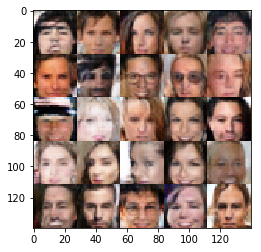

Epoch 1/1 - Batch 2510/202599:  Discriminator Loss: 1.3073 Generator Loss: 0.7068
Epoch 1/1 - Batch 2520/202599:  Discriminator Loss: 1.3483 Generator Loss: 0.6981
Epoch 1/1 - Batch 2530/202599:  Discriminator Loss: 1.4647 Generator Loss: 0.5596
Epoch 1/1 - Batch 2540/202599:  Discriminator Loss: 1.3715 Generator Loss: 0.6656
Epoch 1/1 - Batch 2550/202599:  Discriminator Loss: 1.5400 Generator Loss: 0.5212
Epoch 1/1 - Batch 2560/202599:  Discriminator Loss: 1.1949 Generator Loss: 0.8463
Epoch 1/1 - Batch 2570/202599:  Discriminator Loss: 1.5346 Generator Loss: 0.6490
Epoch 1/1 - Batch 2580/202599:  Discriminator Loss: 1.3104 Generator Loss: 0.8519
Epoch 1/1 - Batch 2590/202599:  Discriminator Loss: 1.5171 Generator Loss: 0.5509
Epoch 1/1 - Batch 2600/202599:  Discriminator Loss: 1.4958 Generator Loss: 0.6465


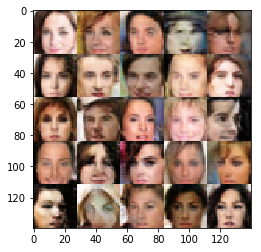

Epoch 1/1 - Batch 2610/202599:  Discriminator Loss: 1.3703 Generator Loss: 0.6944
Epoch 1/1 - Batch 2620/202599:  Discriminator Loss: 1.2189 Generator Loss: 0.8925
Epoch 1/1 - Batch 2630/202599:  Discriminator Loss: 1.5164 Generator Loss: 0.5724
Epoch 1/1 - Batch 2640/202599:  Discriminator Loss: 1.4011 Generator Loss: 0.5646
Epoch 1/1 - Batch 2650/202599:  Discriminator Loss: 1.3653 Generator Loss: 0.6684
Epoch 1/1 - Batch 2660/202599:  Discriminator Loss: 1.4708 Generator Loss: 0.6043
Epoch 1/1 - Batch 2670/202599:  Discriminator Loss: 1.4378 Generator Loss: 0.6335
Epoch 1/1 - Batch 2680/202599:  Discriminator Loss: 1.6992 Generator Loss: 1.5921
Epoch 1/1 - Batch 2690/202599:  Discriminator Loss: 1.4166 Generator Loss: 0.6161
Epoch 1/1 - Batch 2700/202599:  Discriminator Loss: 1.4126 Generator Loss: 0.5972


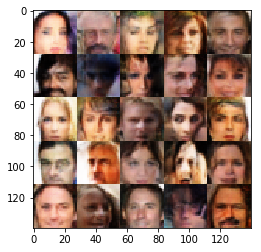

Epoch 1/1 - Batch 2710/202599:  Discriminator Loss: 1.3683 Generator Loss: 0.6356
Epoch 1/1 - Batch 2720/202599:  Discriminator Loss: 1.3761 Generator Loss: 0.6265
Epoch 1/1 - Batch 2730/202599:  Discriminator Loss: 1.3457 Generator Loss: 0.7639
Epoch 1/1 - Batch 2740/202599:  Discriminator Loss: 1.3579 Generator Loss: 0.8109
Epoch 1/1 - Batch 2750/202599:  Discriminator Loss: 1.3143 Generator Loss: 0.7049
Epoch 1/1 - Batch 2760/202599:  Discriminator Loss: 1.4648 Generator Loss: 0.5646
Epoch 1/1 - Batch 2770/202599:  Discriminator Loss: 1.3767 Generator Loss: 0.7573
Epoch 1/1 - Batch 2780/202599:  Discriminator Loss: 1.3027 Generator Loss: 0.6428
Epoch 1/1 - Batch 2790/202599:  Discriminator Loss: 1.2321 Generator Loss: 0.7862
Epoch 1/1 - Batch 2800/202599:  Discriminator Loss: 1.4242 Generator Loss: 0.4927


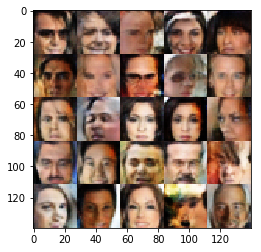

Epoch 1/1 - Batch 2810/202599:  Discriminator Loss: 1.5173 Generator Loss: 0.4923
Epoch 1/1 - Batch 2820/202599:  Discriminator Loss: 1.3862 Generator Loss: 0.5515
Epoch 1/1 - Batch 2830/202599:  Discriminator Loss: 1.3857 Generator Loss: 0.6376
Epoch 1/1 - Batch 2840/202599:  Discriminator Loss: 1.2566 Generator Loss: 0.6965
Epoch 1/1 - Batch 2850/202599:  Discriminator Loss: 1.2325 Generator Loss: 0.8242
Epoch 1/1 - Batch 2860/202599:  Discriminator Loss: 1.3574 Generator Loss: 0.6694
Epoch 1/1 - Batch 2870/202599:  Discriminator Loss: 0.8905 Generator Loss: 1.1340
Epoch 1/1 - Batch 2880/202599:  Discriminator Loss: 1.0944 Generator Loss: 0.7086
Epoch 1/1 - Batch 2890/202599:  Discriminator Loss: 1.1998 Generator Loss: 0.8067
Epoch 1/1 - Batch 2900/202599:  Discriminator Loss: 1.4583 Generator Loss: 0.8791


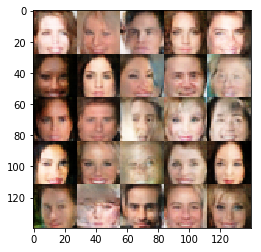

Epoch 1/1 - Batch 2910/202599:  Discriminator Loss: 1.3622 Generator Loss: 0.7132
Epoch 1/1 - Batch 2920/202599:  Discriminator Loss: 1.4213 Generator Loss: 0.7540
Epoch 1/1 - Batch 2930/202599:  Discriminator Loss: 1.3629 Generator Loss: 0.6856
Epoch 1/1 - Batch 2940/202599:  Discriminator Loss: 1.3394 Generator Loss: 0.7359
Epoch 1/1 - Batch 2950/202599:  Discriminator Loss: 1.3247 Generator Loss: 0.6430
Epoch 1/1 - Batch 2960/202599:  Discriminator Loss: 1.1927 Generator Loss: 0.8673
Epoch 1/1 - Batch 2970/202599:  Discriminator Loss: 1.3543 Generator Loss: 0.5730
Epoch 1/1 - Batch 2980/202599:  Discriminator Loss: 1.3534 Generator Loss: 0.7699
Epoch 1/1 - Batch 2990/202599:  Discriminator Loss: 1.4215 Generator Loss: 0.6812
Epoch 1/1 - Batch 3000/202599:  Discriminator Loss: 1.3588 Generator Loss: 0.6067


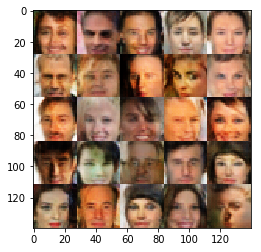

Epoch 1/1 - Batch 3010/202599:  Discriminator Loss: 1.5034 Generator Loss: 0.4636
Epoch 1/1 - Batch 3020/202599:  Discriminator Loss: 1.2990 Generator Loss: 0.6217
Epoch 1/1 - Batch 3030/202599:  Discriminator Loss: 1.3563 Generator Loss: 0.6600
Epoch 1/1 - Batch 3040/202599:  Discriminator Loss: 1.3207 Generator Loss: 0.8188
Epoch 1/1 - Batch 3050/202599:  Discriminator Loss: 1.3129 Generator Loss: 0.7611
Epoch 1/1 - Batch 3060/202599:  Discriminator Loss: 1.1328 Generator Loss: 0.9615
Epoch 1/1 - Batch 3070/202599:  Discriminator Loss: 1.1811 Generator Loss: 0.7774
Epoch 1/1 - Batch 3080/202599:  Discriminator Loss: 1.1446 Generator Loss: 0.8575
Epoch 1/1 - Batch 3090/202599:  Discriminator Loss: 1.6181 Generator Loss: 0.4243
Epoch 1/1 - Batch 3100/202599:  Discriminator Loss: 1.3117 Generator Loss: 0.6761


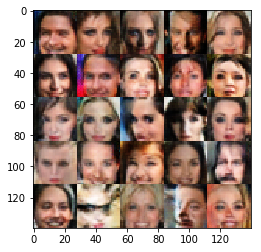

Epoch 1/1 - Batch 3110/202599:  Discriminator Loss: 1.4240 Generator Loss: 0.6559
Epoch 1/1 - Batch 3120/202599:  Discriminator Loss: 1.4542 Generator Loss: 0.5609
Epoch 1/1 - Batch 3130/202599:  Discriminator Loss: 1.3521 Generator Loss: 0.7261
Epoch 1/1 - Batch 3140/202599:  Discriminator Loss: 1.4453 Generator Loss: 0.6440
Epoch 1/1 - Batch 3150/202599:  Discriminator Loss: 1.5619 Generator Loss: 0.4498
Epoch 1/1 - Batch 3160/202599:  Discriminator Loss: 1.3954 Generator Loss: 0.7224
Epoch 1/1 - Batch 10/202599:  Discriminator Loss: 1.4371 Generator Loss: 0.5238
Epoch 1/1 - Batch 20/202599:  Discriminator Loss: 1.6445 Generator Loss: 0.4089
Epoch 1/1 - Batch 30/202599:  Discriminator Loss: 1.4873 Generator Loss: 0.4574
Epoch 1/1 - Batch 40/202599:  Discriminator Loss: 1.3787 Generator Loss: 0.5646
Epoch 1/1 - Batch 50/202599:  Discriminator Loss: 1.2690 Generator Loss: 0.7650
Epoch 1/1 - Batch 60/202599:  Discriminator Loss: 1.0759 Generator Loss: 0.8215
Epoch 1/1 - Batch 70/202599:

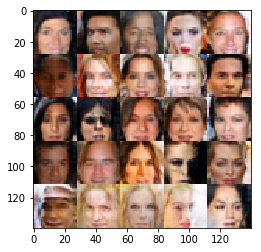

Epoch 1/1 - Batch 110/202599:  Discriminator Loss: 1.5087 Generator Loss: 0.4811
Epoch 1/1 - Batch 120/202599:  Discriminator Loss: 1.5064 Generator Loss: 0.4856
Epoch 1/1 - Batch 130/202599:  Discriminator Loss: 1.4024 Generator Loss: 0.8683
Epoch 1/1 - Batch 140/202599:  Discriminator Loss: 1.3594 Generator Loss: 0.6882
Epoch 1/1 - Batch 150/202599:  Discriminator Loss: 1.4206 Generator Loss: 0.6440
Epoch 1/1 - Batch 160/202599:  Discriminator Loss: 1.6004 Generator Loss: 0.5370
Epoch 1/1 - Batch 170/202599:  Discriminator Loss: 1.3598 Generator Loss: 0.6925
Epoch 1/1 - Batch 180/202599:  Discriminator Loss: 1.2677 Generator Loss: 0.6720
Epoch 1/1 - Batch 190/202599:  Discriminator Loss: 1.2699 Generator Loss: 0.8371
Epoch 1/1 - Batch 200/202599:  Discriminator Loss: 1.4200 Generator Loss: 0.6692


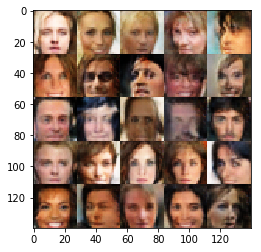

Epoch 1/1 - Batch 210/202599:  Discriminator Loss: 1.2994 Generator Loss: 1.0405
Epoch 1/1 - Batch 220/202599:  Discriminator Loss: 0.9816 Generator Loss: 1.0897
Epoch 1/1 - Batch 230/202599:  Discriminator Loss: 1.1748 Generator Loss: 0.8775
Epoch 1/1 - Batch 240/202599:  Discriminator Loss: 1.5824 Generator Loss: 0.4746
Epoch 1/1 - Batch 250/202599:  Discriminator Loss: 1.5087 Generator Loss: 0.5662
Epoch 1/1 - Batch 260/202599:  Discriminator Loss: 1.5775 Generator Loss: 0.6025
Epoch 1/1 - Batch 270/202599:  Discriminator Loss: 1.3859 Generator Loss: 0.7070
Epoch 1/1 - Batch 280/202599:  Discriminator Loss: 1.3191 Generator Loss: 0.6118
Epoch 1/1 - Batch 290/202599:  Discriminator Loss: 1.1553 Generator Loss: 0.9316
Epoch 1/1 - Batch 300/202599:  Discriminator Loss: 1.5712 Generator Loss: 0.5720


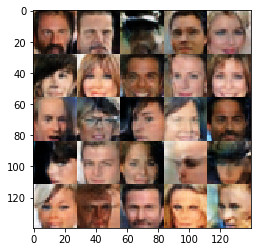

Epoch 1/1 - Batch 310/202599:  Discriminator Loss: 1.2624 Generator Loss: 0.6714
Epoch 1/1 - Batch 320/202599:  Discriminator Loss: 1.4780 Generator Loss: 0.5547
Epoch 1/1 - Batch 330/202599:  Discriminator Loss: 1.3987 Generator Loss: 0.6178
Epoch 1/1 - Batch 340/202599:  Discriminator Loss: 1.3139 Generator Loss: 0.8102
Epoch 1/1 - Batch 350/202599:  Discriminator Loss: 1.2772 Generator Loss: 1.0553
Epoch 1/1 - Batch 360/202599:  Discriminator Loss: 1.3250 Generator Loss: 0.6238
Epoch 1/1 - Batch 370/202599:  Discriminator Loss: 1.4255 Generator Loss: 0.6144
Epoch 1/1 - Batch 380/202599:  Discriminator Loss: 1.3117 Generator Loss: 0.7012
Epoch 1/1 - Batch 390/202599:  Discriminator Loss: 1.4054 Generator Loss: 0.6291
Epoch 1/1 - Batch 400/202599:  Discriminator Loss: 1.3099 Generator Loss: 0.8432


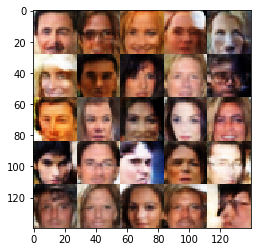

Epoch 1/1 - Batch 410/202599:  Discriminator Loss: 1.2808 Generator Loss: 0.8625
Epoch 1/1 - Batch 420/202599:  Discriminator Loss: 1.3758 Generator Loss: 0.6994
Epoch 1/1 - Batch 430/202599:  Discriminator Loss: 1.2901 Generator Loss: 0.7116
Epoch 1/1 - Batch 440/202599:  Discriminator Loss: 1.4450 Generator Loss: 0.5586
Epoch 1/1 - Batch 450/202599:  Discriminator Loss: 1.3704 Generator Loss: 0.6315
Epoch 1/1 - Batch 460/202599:  Discriminator Loss: 1.2760 Generator Loss: 0.9070
Epoch 1/1 - Batch 470/202599:  Discriminator Loss: 1.8217 Generator Loss: 0.3180
Epoch 1/1 - Batch 480/202599:  Discriminator Loss: 1.4290 Generator Loss: 0.6297
Epoch 1/1 - Batch 490/202599:  Discriminator Loss: 1.2848 Generator Loss: 0.9304
Epoch 1/1 - Batch 500/202599:  Discriminator Loss: 1.3457 Generator Loss: 0.6065


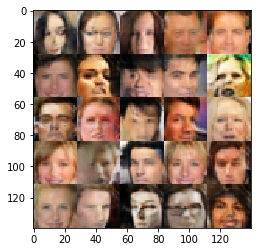

Epoch 1/1 - Batch 510/202599:  Discriminator Loss: 1.5063 Generator Loss: 0.5227
Epoch 1/1 - Batch 520/202599:  Discriminator Loss: 1.5103 Generator Loss: 0.4976
Epoch 1/1 - Batch 530/202599:  Discriminator Loss: 1.4551 Generator Loss: 0.6051
Epoch 1/1 - Batch 540/202599:  Discriminator Loss: 1.3464 Generator Loss: 0.7169
Epoch 1/1 - Batch 550/202599:  Discriminator Loss: 1.4186 Generator Loss: 0.5616
Epoch 1/1 - Batch 560/202599:  Discriminator Loss: 1.5435 Generator Loss: 0.4884
Epoch 1/1 - Batch 570/202599:  Discriminator Loss: 1.1437 Generator Loss: 0.9723
Epoch 1/1 - Batch 580/202599:  Discriminator Loss: 1.4240 Generator Loss: 0.5060
Epoch 1/1 - Batch 590/202599:  Discriminator Loss: 1.5104 Generator Loss: 0.5950
Epoch 1/1 - Batch 600/202599:  Discriminator Loss: 1.3684 Generator Loss: 0.5751


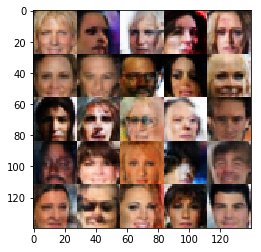

Epoch 1/1 - Batch 610/202599:  Discriminator Loss: 1.5113 Generator Loss: 0.5934
Epoch 1/1 - Batch 620/202599:  Discriminator Loss: 1.4783 Generator Loss: 0.5681
Epoch 1/1 - Batch 630/202599:  Discriminator Loss: 1.3219 Generator Loss: 0.6341
Epoch 1/1 - Batch 640/202599:  Discriminator Loss: 1.3962 Generator Loss: 0.7811
Epoch 1/1 - Batch 650/202599:  Discriminator Loss: 1.3456 Generator Loss: 0.6173
Epoch 1/1 - Batch 660/202599:  Discriminator Loss: 1.4407 Generator Loss: 0.5698
Epoch 1/1 - Batch 670/202599:  Discriminator Loss: 1.5468 Generator Loss: 0.5061
Epoch 1/1 - Batch 680/202599:  Discriminator Loss: 1.3343 Generator Loss: 0.7079
Epoch 1/1 - Batch 690/202599:  Discriminator Loss: 1.4676 Generator Loss: 0.4967
Epoch 1/1 - Batch 700/202599:  Discriminator Loss: 1.5285 Generator Loss: 0.5016


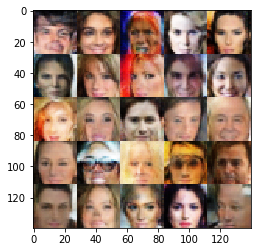

Epoch 1/1 - Batch 710/202599:  Discriminator Loss: 1.3572 Generator Loss: 0.6293
Epoch 1/1 - Batch 720/202599:  Discriminator Loss: 1.4194 Generator Loss: 0.6154
Epoch 1/1 - Batch 730/202599:  Discriminator Loss: 1.2666 Generator Loss: 0.6227
Epoch 1/1 - Batch 740/202599:  Discriminator Loss: 1.0339 Generator Loss: 1.1331
Epoch 1/1 - Batch 750/202599:  Discriminator Loss: 1.4157 Generator Loss: 0.5878
Epoch 1/1 - Batch 760/202599:  Discriminator Loss: 1.3905 Generator Loss: 0.6150
Epoch 1/1 - Batch 770/202599:  Discriminator Loss: 1.6275 Generator Loss: 0.4799
Epoch 1/1 - Batch 780/202599:  Discriminator Loss: 1.2835 Generator Loss: 0.9385
Epoch 1/1 - Batch 790/202599:  Discriminator Loss: 1.3977 Generator Loss: 0.6846
Epoch 1/1 - Batch 800/202599:  Discriminator Loss: 1.3156 Generator Loss: 0.6507


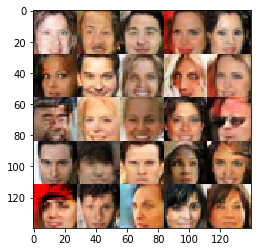

Epoch 1/1 - Batch 810/202599:  Discriminator Loss: 1.5579 Generator Loss: 0.5111
Epoch 1/1 - Batch 820/202599:  Discriminator Loss: 1.8783 Generator Loss: 0.3400
Epoch 1/1 - Batch 830/202599:  Discriminator Loss: 1.1876 Generator Loss: 0.8112
Epoch 1/1 - Batch 840/202599:  Discriminator Loss: 1.2734 Generator Loss: 0.6043
Epoch 1/1 - Batch 850/202599:  Discriminator Loss: 1.3387 Generator Loss: 0.9386
Epoch 1/1 - Batch 860/202599:  Discriminator Loss: 1.3431 Generator Loss: 0.8322
Epoch 1/1 - Batch 870/202599:  Discriminator Loss: 1.3452 Generator Loss: 0.6670
Epoch 1/1 - Batch 880/202599:  Discriminator Loss: 1.4117 Generator Loss: 0.5769
Epoch 1/1 - Batch 890/202599:  Discriminator Loss: 1.2182 Generator Loss: 0.7976
Epoch 1/1 - Batch 900/202599:  Discriminator Loss: 1.3777 Generator Loss: 0.7359


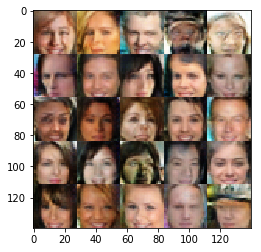

Epoch 1/1 - Batch 910/202599:  Discriminator Loss: 1.4174 Generator Loss: 0.6038
Epoch 1/1 - Batch 920/202599:  Discriminator Loss: 1.4956 Generator Loss: 0.5610
Epoch 1/1 - Batch 930/202599:  Discriminator Loss: 1.4401 Generator Loss: 0.6271
Epoch 1/1 - Batch 940/202599:  Discriminator Loss: 1.4614 Generator Loss: 0.5672
Epoch 1/1 - Batch 950/202599:  Discriminator Loss: 1.4682 Generator Loss: 0.6808
Epoch 1/1 - Batch 960/202599:  Discriminator Loss: 1.2921 Generator Loss: 0.7283
Epoch 1/1 - Batch 970/202599:  Discriminator Loss: 1.4900 Generator Loss: 0.5540
Epoch 1/1 - Batch 980/202599:  Discriminator Loss: 1.3331 Generator Loss: 0.7442
Epoch 1/1 - Batch 990/202599:  Discriminator Loss: 1.2258 Generator Loss: 0.7008
Epoch 1/1 - Batch 1000/202599:  Discriminator Loss: 1.3458 Generator Loss: 0.6924


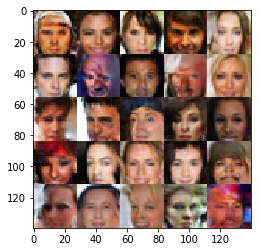

Epoch 1/1 - Batch 1010/202599:  Discriminator Loss: 1.4554 Generator Loss: 0.6271
Epoch 1/1 - Batch 1020/202599:  Discriminator Loss: 1.4093 Generator Loss: 0.5567
Epoch 1/1 - Batch 1030/202599:  Discriminator Loss: 1.4678 Generator Loss: 0.5177
Epoch 1/1 - Batch 1040/202599:  Discriminator Loss: 1.4082 Generator Loss: 0.5541
Epoch 1/1 - Batch 1050/202599:  Discriminator Loss: 1.2710 Generator Loss: 0.7365
Epoch 1/1 - Batch 1060/202599:  Discriminator Loss: 1.3338 Generator Loss: 0.6146
Epoch 1/1 - Batch 1070/202599:  Discriminator Loss: 1.4826 Generator Loss: 0.5262
Epoch 1/1 - Batch 1080/202599:  Discriminator Loss: 1.1205 Generator Loss: 0.8508
Epoch 1/1 - Batch 1090/202599:  Discriminator Loss: 1.1908 Generator Loss: 0.8393
Epoch 1/1 - Batch 1100/202599:  Discriminator Loss: 1.5668 Generator Loss: 0.4119


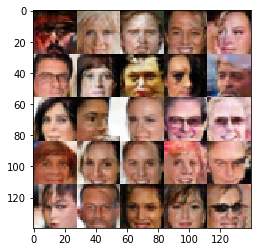

Epoch 1/1 - Batch 1110/202599:  Discriminator Loss: 1.5138 Generator Loss: 0.6131
Epoch 1/1 - Batch 1120/202599:  Discriminator Loss: 1.5272 Generator Loss: 0.5575
Epoch 1/1 - Batch 1130/202599:  Discriminator Loss: 1.4854 Generator Loss: 0.5355
Epoch 1/1 - Batch 1140/202599:  Discriminator Loss: 1.6718 Generator Loss: 0.3827
Epoch 1/1 - Batch 1150/202599:  Discriminator Loss: 1.2428 Generator Loss: 0.6955
Epoch 1/1 - Batch 1160/202599:  Discriminator Loss: 2.0183 Generator Loss: 0.2879
Epoch 1/1 - Batch 1170/202599:  Discriminator Loss: 1.3531 Generator Loss: 0.6429
Epoch 1/1 - Batch 1180/202599:  Discriminator Loss: 1.3803 Generator Loss: 0.6677
Epoch 1/1 - Batch 1190/202599:  Discriminator Loss: 1.3244 Generator Loss: 0.7154
Epoch 1/1 - Batch 1200/202599:  Discriminator Loss: 1.3090 Generator Loss: 0.9979


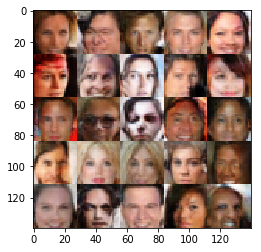

Epoch 1/1 - Batch 1210/202599:  Discriminator Loss: 1.3842 Generator Loss: 0.5547
Epoch 1/1 - Batch 1220/202599:  Discriminator Loss: 1.2695 Generator Loss: 1.0485
Epoch 1/1 - Batch 1230/202599:  Discriminator Loss: 1.5263 Generator Loss: 0.4742
Epoch 1/1 - Batch 1240/202599:  Discriminator Loss: 1.4032 Generator Loss: 0.6284
Epoch 1/1 - Batch 1250/202599:  Discriminator Loss: 1.5005 Generator Loss: 0.5166
Epoch 1/1 - Batch 1260/202599:  Discriminator Loss: 1.7391 Generator Loss: 0.3280
Epoch 1/1 - Batch 1270/202599:  Discriminator Loss: 1.2233 Generator Loss: 1.7130
Epoch 1/1 - Batch 1280/202599:  Discriminator Loss: 1.5856 Generator Loss: 0.5221
Epoch 1/1 - Batch 1290/202599:  Discriminator Loss: 1.5073 Generator Loss: 0.5536
Epoch 1/1 - Batch 1300/202599:  Discriminator Loss: 1.4062 Generator Loss: 0.5918


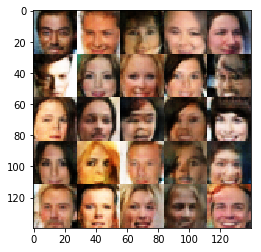

Epoch 1/1 - Batch 1310/202599:  Discriminator Loss: 1.4611 Generator Loss: 0.6530
Epoch 1/1 - Batch 1320/202599:  Discriminator Loss: 1.3355 Generator Loss: 0.6154
Epoch 1/1 - Batch 1330/202599:  Discriminator Loss: 1.5634 Generator Loss: 0.5130
Epoch 1/1 - Batch 1340/202599:  Discriminator Loss: 1.3857 Generator Loss: 0.6185
Epoch 1/1 - Batch 1350/202599:  Discriminator Loss: 1.4959 Generator Loss: 0.4908
Epoch 1/1 - Batch 1360/202599:  Discriminator Loss: 1.1179 Generator Loss: 0.9456
Epoch 1/1 - Batch 1370/202599:  Discriminator Loss: 1.4658 Generator Loss: 0.5247
Epoch 1/1 - Batch 1380/202599:  Discriminator Loss: 1.5800 Generator Loss: 0.4401
Epoch 1/1 - Batch 1390/202599:  Discriminator Loss: 1.3869 Generator Loss: 0.9820
Epoch 1/1 - Batch 1400/202599:  Discriminator Loss: 1.4344 Generator Loss: 0.5297


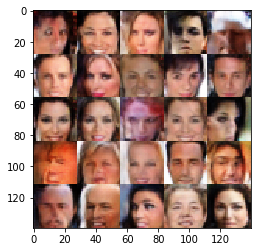

Epoch 1/1 - Batch 1410/202599:  Discriminator Loss: 1.4459 Generator Loss: 0.6702
Epoch 1/1 - Batch 1420/202599:  Discriminator Loss: 1.3607 Generator Loss: 0.6971
Epoch 1/1 - Batch 1430/202599:  Discriminator Loss: 1.5535 Generator Loss: 0.5316
Epoch 1/1 - Batch 1440/202599:  Discriminator Loss: 1.3223 Generator Loss: 0.8249
Epoch 1/1 - Batch 1450/202599:  Discriminator Loss: 1.4117 Generator Loss: 0.6202
Epoch 1/1 - Batch 1460/202599:  Discriminator Loss: 1.5042 Generator Loss: 0.4985
Epoch 1/1 - Batch 1470/202599:  Discriminator Loss: 1.5388 Generator Loss: 0.5510
Epoch 1/1 - Batch 1480/202599:  Discriminator Loss: 1.1965 Generator Loss: 0.9176
Epoch 1/1 - Batch 1490/202599:  Discriminator Loss: 1.4951 Generator Loss: 0.6460
Epoch 1/1 - Batch 1500/202599:  Discriminator Loss: 1.3972 Generator Loss: 0.7185


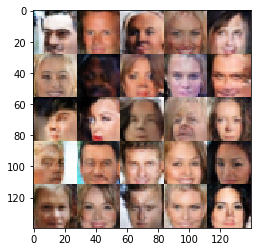

Epoch 1/1 - Batch 1510/202599:  Discriminator Loss: 1.2948 Generator Loss: 0.7972
Epoch 1/1 - Batch 1520/202599:  Discriminator Loss: 1.4295 Generator Loss: 0.6816
Epoch 1/1 - Batch 1530/202599:  Discriminator Loss: 1.3150 Generator Loss: 0.7437
Epoch 1/1 - Batch 1540/202599:  Discriminator Loss: 1.5062 Generator Loss: 0.5215
Epoch 1/1 - Batch 1550/202599:  Discriminator Loss: 1.4409 Generator Loss: 0.6815
Epoch 1/1 - Batch 1560/202599:  Discriminator Loss: 1.3999 Generator Loss: 0.5502
Epoch 1/1 - Batch 1570/202599:  Discriminator Loss: 1.2823 Generator Loss: 0.7761
Epoch 1/1 - Batch 1580/202599:  Discriminator Loss: 1.5498 Generator Loss: 0.4555
Epoch 1/1 - Batch 1590/202599:  Discriminator Loss: 1.3584 Generator Loss: 0.7095
Epoch 1/1 - Batch 1600/202599:  Discriminator Loss: 1.1922 Generator Loss: 0.7774


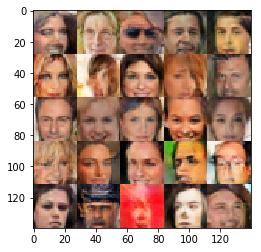

Epoch 1/1 - Batch 1610/202599:  Discriminator Loss: 1.6302 Generator Loss: 0.5060
Epoch 1/1 - Batch 1620/202599:  Discriminator Loss: 1.3483 Generator Loss: 0.6547
Epoch 1/1 - Batch 1630/202599:  Discriminator Loss: 1.4746 Generator Loss: 0.5501
Epoch 1/1 - Batch 1640/202599:  Discriminator Loss: 1.1556 Generator Loss: 0.9759
Epoch 1/1 - Batch 1650/202599:  Discriminator Loss: 1.7015 Generator Loss: 0.3467
Epoch 1/1 - Batch 1660/202599:  Discriminator Loss: 1.3573 Generator Loss: 0.7278
Epoch 1/1 - Batch 1670/202599:  Discriminator Loss: 1.2822 Generator Loss: 0.8359
Epoch 1/1 - Batch 1680/202599:  Discriminator Loss: 1.4836 Generator Loss: 0.5336
Epoch 1/1 - Batch 1690/202599:  Discriminator Loss: 1.3801 Generator Loss: 0.6011
Epoch 1/1 - Batch 1700/202599:  Discriminator Loss: 1.6758 Generator Loss: 0.3721


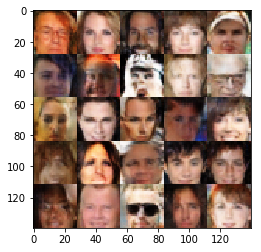

Epoch 1/1 - Batch 1710/202599:  Discriminator Loss: 1.5439 Generator Loss: 0.4280
Epoch 1/1 - Batch 1720/202599:  Discriminator Loss: 1.1913 Generator Loss: 0.7501
Epoch 1/1 - Batch 1730/202599:  Discriminator Loss: 1.4611 Generator Loss: 0.5443
Epoch 1/1 - Batch 1740/202599:  Discriminator Loss: 1.2337 Generator Loss: 0.7765
Epoch 1/1 - Batch 1750/202599:  Discriminator Loss: 1.5376 Generator Loss: 0.5063
Epoch 1/1 - Batch 1760/202599:  Discriminator Loss: 1.3996 Generator Loss: 0.6205
Epoch 1/1 - Batch 1770/202599:  Discriminator Loss: 1.3295 Generator Loss: 0.6235
Epoch 1/1 - Batch 1780/202599:  Discriminator Loss: 1.4739 Generator Loss: 0.5620
Epoch 1/1 - Batch 1790/202599:  Discriminator Loss: 1.4088 Generator Loss: 0.6900
Epoch 1/1 - Batch 1800/202599:  Discriminator Loss: 1.5589 Generator Loss: 0.4742


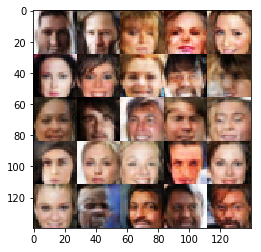

Epoch 1/1 - Batch 1810/202599:  Discriminator Loss: 1.5036 Generator Loss: 0.4929
Epoch 1/1 - Batch 1820/202599:  Discriminator Loss: 1.3932 Generator Loss: 0.5906
Epoch 1/1 - Batch 1830/202599:  Discriminator Loss: 1.6068 Generator Loss: 0.4796
Epoch 1/1 - Batch 1840/202599:  Discriminator Loss: 1.3110 Generator Loss: 0.6568
Epoch 1/1 - Batch 1850/202599:  Discriminator Loss: 1.3709 Generator Loss: 0.6187
Epoch 1/1 - Batch 1860/202599:  Discriminator Loss: 1.6758 Generator Loss: 0.4487
Epoch 1/1 - Batch 1870/202599:  Discriminator Loss: 1.3341 Generator Loss: 0.7330
Epoch 1/1 - Batch 1880/202599:  Discriminator Loss: 1.5338 Generator Loss: 0.4922
Epoch 1/1 - Batch 1890/202599:  Discriminator Loss: 1.4550 Generator Loss: 0.5719
Epoch 1/1 - Batch 1900/202599:  Discriminator Loss: 1.4872 Generator Loss: 0.6450


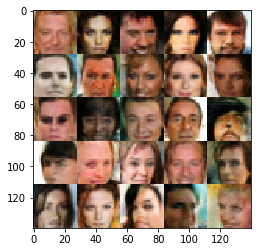

Epoch 1/1 - Batch 1910/202599:  Discriminator Loss: 1.4142 Generator Loss: 0.6035
Epoch 1/1 - Batch 1920/202599:  Discriminator Loss: 1.2591 Generator Loss: 0.7413
Epoch 1/1 - Batch 1930/202599:  Discriminator Loss: 1.6608 Generator Loss: 0.4220
Epoch 1/1 - Batch 1940/202599:  Discriminator Loss: 1.3310 Generator Loss: 0.7943
Epoch 1/1 - Batch 1950/202599:  Discriminator Loss: 1.4053 Generator Loss: 0.5508
Epoch 1/1 - Batch 1960/202599:  Discriminator Loss: 1.3145 Generator Loss: 0.6954
Epoch 1/1 - Batch 1970/202599:  Discriminator Loss: 1.5869 Generator Loss: 0.5068
Epoch 1/1 - Batch 1980/202599:  Discriminator Loss: 1.7288 Generator Loss: 0.5129
Epoch 1/1 - Batch 1990/202599:  Discriminator Loss: 1.4077 Generator Loss: 0.5984
Epoch 1/1 - Batch 2000/202599:  Discriminator Loss: 1.3119 Generator Loss: 0.7138


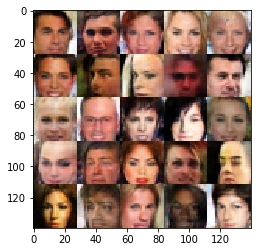

Epoch 1/1 - Batch 2010/202599:  Discriminator Loss: 1.4551 Generator Loss: 0.7954
Epoch 1/1 - Batch 2020/202599:  Discriminator Loss: 1.2906 Generator Loss: 0.6793
Epoch 1/1 - Batch 2030/202599:  Discriminator Loss: 1.6105 Generator Loss: 0.5080
Epoch 1/1 - Batch 2040/202599:  Discriminator Loss: 1.1606 Generator Loss: 0.7828
Epoch 1/1 - Batch 2050/202599:  Discriminator Loss: 1.2271 Generator Loss: 0.7440
Epoch 1/1 - Batch 2060/202599:  Discriminator Loss: 1.7929 Generator Loss: 0.3924
Epoch 1/1 - Batch 2070/202599:  Discriminator Loss: 1.3573 Generator Loss: 0.5394
Epoch 1/1 - Batch 2080/202599:  Discriminator Loss: 1.3526 Generator Loss: 0.6131
Epoch 1/1 - Batch 2090/202599:  Discriminator Loss: 1.3881 Generator Loss: 0.6264
Epoch 1/1 - Batch 2100/202599:  Discriminator Loss: 1.2874 Generator Loss: 0.7984


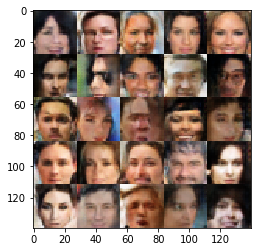

Epoch 1/1 - Batch 2110/202599:  Discriminator Loss: 1.4525 Generator Loss: 0.5301
Epoch 1/1 - Batch 2120/202599:  Discriminator Loss: 1.4909 Generator Loss: 0.5639
Epoch 1/1 - Batch 2130/202599:  Discriminator Loss: 1.1725 Generator Loss: 1.0119
Epoch 1/1 - Batch 2140/202599:  Discriminator Loss: 1.2199 Generator Loss: 0.8167
Epoch 1/1 - Batch 2150/202599:  Discriminator Loss: 1.4395 Generator Loss: 0.5999
Epoch 1/1 - Batch 2160/202599:  Discriminator Loss: 1.2798 Generator Loss: 0.7650
Epoch 1/1 - Batch 2170/202599:  Discriminator Loss: 1.3306 Generator Loss: 0.8281
Epoch 1/1 - Batch 2180/202599:  Discriminator Loss: 1.4909 Generator Loss: 0.6958
Epoch 1/1 - Batch 2190/202599:  Discriminator Loss: 1.5959 Generator Loss: 0.4501
Epoch 1/1 - Batch 2200/202599:  Discriminator Loss: 1.4348 Generator Loss: 1.1082


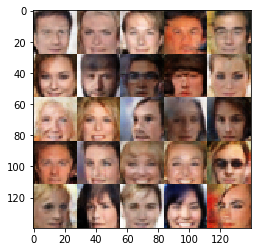

Epoch 1/1 - Batch 2210/202599:  Discriminator Loss: 1.6113 Generator Loss: 0.4117
Epoch 1/1 - Batch 2220/202599:  Discriminator Loss: 1.2249 Generator Loss: 0.7001
Epoch 1/1 - Batch 2230/202599:  Discriminator Loss: 1.3910 Generator Loss: 0.5662


In [ ]:
batch_size = 64
z_dim = 120
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.